<a href="https://colab.research.google.com/github/GuptaTanay/Battery-Level-Prediction/blob/main/Battery_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AIM
Aim of this project is to compare most of all of the possible Time Series models and chose the model with best accuracy and less errors on a given dataset.

Importing file  to Google colab.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Installing required packages.

In [ ]:
# !pip install prophet
# !pip install statsmodels --upgrade
# !pip install sklearn --upgrade

Importing required packages.

In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot  as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,mean_absolute_error , accuracy_score,classification_report
#, confusion_matrix
# from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
import datetime
import warnings
warnings.filterwarnings('ignore')

1. Importing the dataset for performing  Exponential Data Analysis (EDA)

In [ ]:
data = pd.read_excel('BatteryLogs.xlsx')

In [ ]:
data.head()

timestamp                             scode  level
0  2021-04-23 07:44:08  3320e01c4f1d6fa898adbeda981150dc      6
1  2021-04-23 07:04:07  ea05a2a12ce40e29289cc6dd9587b665      7
2  2021-04-22 14:56:25  ca1441c0b8503ef6e77620bf602dae49      4
3  2021-04-22 14:47:49  ca1441c0b8503ef6e77620bf602dae49      4
4  2021-04-22 13:51:47  c47b970da888de5b0c0f299ed8a0cda7      2

We could see from the below cell that there are 585 rows in total in the dataset, and there are no NULLS in the dataset.
There are 3 columns:-
1. Timestamp : Contains time in datetimeformat.
2. scode: Unique IDs representing a unique session code.
3. level: Level of the battery for that particular session at a time.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  585 non-null    object
 1   scode      585 non-null    object
 2   level      585 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.8+ KB


Below cell let us know that there are 24unique session codes in total.

In [ ]:
data.scode.nunique()

24

The number of levels in each scode is given by the below cell.

We can see that there are some session codes which have very less number of observations.

In [ ]:
data.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
c67cd9070c66fa4ba123d57c545bee28    27
ea05a2a12ce40e29289cc6dd9587b665    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
547b07145a4af0bdcb026af8af3f5b05    14
7ebae810262304e22c8290f106bb9b7d    14
0057f94ed9cf672d1866745ca2324ac7    12
1be7b4ec4330e1fb03e56aa7e81368cb     6
bff3b24e342349f7eda673ee6228aeba     5
e4c48703b9319fd7b9132ff9080c69c3     3
cf84ad34de243829c53d5b3e83c500f5     2
afd7215063859ee8ff44731986839859     2
f96ad41c1d11394382264ca085d21945     2
baee826a63b428981915076a9c6cd6a0     2
58077f6af4a2135bd0c743dfa0b020a8     1
Name: scode, dtype: int64

Since, Time series require historical data to learn the trend, seasons,  stationarity. Based on that, time series is able to predict the future values.
So, we will remove the  values for those session having less than 6 observations.

In [ ]:
counts = data.scode.value_counts()

res = data[~data.scode.isin(counts[counts < 7].index)]

According to the below image(source: Google), the perferct number of observation for a tim series model to learn perfectly should be minium 250. Atleast, 100 number of observations should be there. But, the maximum number of observations for our IDs are 89.



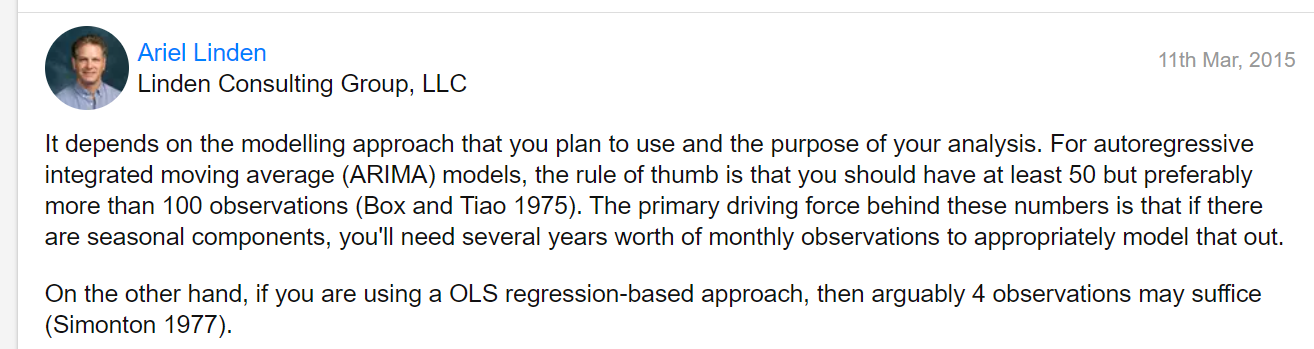

In [ ]:
res.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
c67cd9070c66fa4ba123d57c545bee28    27
ea05a2a12ce40e29289cc6dd9587b665    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
7ebae810262304e22c8290f106bb9b7d    14
547b07145a4af0bdcb026af8af3f5b05    14
0057f94ed9cf672d1866745ca2324ac7    12
Name: scode, dtype: int64

Let us know rename the scode to ID. e.g. first scode will be renamed to id_1, and second as id_2, and so on..

In [ ]:
all_sessions = res['scode'].unique()
session_to_id_map = {}
for i in range(len(all_sessions)):
    session_to_id_map[all_sessions[i]] = 'id_' + str(i+1)

res['scode'] = res['scode'].map(session_to_id_map)
res

timestamp scode  level
0    2021-04-23 07:44:08  id_1      6
1    2021-04-23 07:04:07  id_2      7
2    2021-04-22 14:56:25  id_3      4
3    2021-04-22 14:47:49  id_3      4
4    2021-04-22 13:51:47  id_4      2
..                   ...   ...    ...
580  2020-07-30 07:27:30  id_8      5
581  2020-07-29 20:09:07  id_9      1
582  2020-07-29 19:57:52  id_9      2
583  2020-07-29 19:46:33  id_9      3
584  2020-07-29 13:59:49  id_7      6

[562 rows x 3 columns]

Here we are just analysing each batter level and understanging its count, frequency, etc.

In [ ]:
res[['scode','level']].groupby(['level']).describe()

scode                   
      count unique    top freq
level                         
0         3      2   id_4    2
1        20      8   id_9    6
2        73      9   id_4   39
3        76     11   id_9   20
4        90     13  id_14   14
5       120     15  id_14   21
6       137     12  id_14   44
7        43     11   id_2   14

Since, this problem is time series forecasting and the timestamp column is not sorted. So, we will have to sort the timestap column to make predictions.

In [ ]:
final_data = pd.DataFrame()

unique_scodes = res['scode'].unique()
for scode in unique_scodes:
    data_for_scode = res[ res['scode'] == scode ]
    data_for_scode = data_for_scode.sort_values(by='timestamp')
    final_data = final_data.append(data_for_scode)



In the below  cell,  we are describing the session codes.

In [ ]:
final_data.groupby(['scode']).describe()

level                                               
      count      mean       std  min   25%  50%   75%  max
scode                                                     
id_1   21.0  4.571429  1.247855  1.0  4.00  5.0  5.00  7.0
id_10  14.0  5.642857  0.633324  5.0  5.00  6.0  6.00  7.0
id_11  33.0  3.757576  1.346994  1.0  3.00  4.0  5.00  7.0
id_12  23.0  3.478261  1.274561  1.0  3.00  3.0  4.50  6.0
id_13  27.0  2.888889  1.281025  1.0  2.00  3.0  3.50  7.0
id_14  89.0  5.561798  0.891310  4.0  5.00  6.0  6.00  7.0
id_15  12.0  3.666667  1.370689  1.0  2.75  4.0  5.00  5.0
id_16  14.0  5.642857  1.150728  3.0  5.00  5.5  6.75  7.0
id_2   27.0  6.259259  0.944319  4.0  6.00  7.0  7.00  7.0
id_3   24.0  4.291667  1.428869  0.0  3.75  4.0  5.00  7.0
id_4   51.0  2.078431  1.055332  0.0  2.00  2.0  2.00  6.0
id_5   40.0  4.825000  1.009887  2.0  4.00  5.0  6.00  6.0
id_6   76.0  4.828947  1.454997  2.0  4.00  5.0  6.00  7.0
id_7   26.0  5.884615  0.765607  4.0  5.25  6.0  6.00  7.0
id_8   46.0  4.543478  1.241979  1.0  4.00  5.0  5.00  7.0
id_9   39.0  2.615385  0.906566  1.0  2.00  3.0  3.00  4.0

We we are working on any machine learning problem, we've to make  sure that the data is in correct/ required format or data type. e.g. The  timestamp column should be recorded as date/ datetime data type and not as Object data type.

In [ ]:
final_data.dtypes

timestamp    object
scode        object
level         int64
dtype: object

Now, we will convert the timestamp column to datetime format and move it to the index of  the  dataframe.

In [ ]:
final_data['timestamp']=pd.to_datetime(final_data['timestamp'])

To confirm,  if we got the correct data type now or not.

In [ ]:
final_data.dtypes

timestamp    datetime64[ns]
scode                object
level                 int64
dtype: object

Moving timestamp column to the  index column.

In [ ]:
final_data.set_index('timestamp',inplace=True)

## Nature of Time Series

In time series the order of observations provides a source of additional information that should be analyzed and used in the prediction process. Time series are typically assumed to be generated at regularly spaced interval of time (e.g. daily temperature), and so are called **regular time serie**s. But the data in a time series doesn’t have to come in regular time intervals. In that case it is called **irregular time series.** In irregular time series the data follows a temporal sequence, but the measurements might not occur at a regular time intervals. For example, the data might be generated as a burst or with varying time intervals. Account deposits or withdrawals from an ATM are examples of an irregular time series.

In [ ]:
final_data.head(21)

scode  level
timestamp                       
2020-08-05 08:26:09  id_1      1
2020-09-02 10:54:22  id_1      4
2020-09-07 18:45:19  id_1      5
2020-09-08 17:34:04  id_1      5
2020-09-09 17:32:42  id_1      5
2020-09-17 09:27:40  id_1      5
2020-09-21 09:28:17  id_1      5
2020-09-22 11:49:22  id_1      4
2020-09-22 12:49:37  id_1      2
2020-09-29 09:43:27  id_1      5
2020-10-05 08:22:28  id_1      5
2020-10-13 15:05:16  id_1      5
2020-10-21 17:55:32  id_1      5
2020-10-23 14:41:26  id_1      5
2020-10-27 19:01:38  id_1      4
2020-11-03 08:49:42  id_1      5
2020-12-03 19:39:52  id_1      5
2020-12-23 08:05:24  id_1      4
2021-01-04 11:46:12  id_1      4
2021-01-05 10:28:56  id_1      7
2021-04-23 07:44:08  id_1      6

If we see the time intrvls for ID_1, we can say that the given time series is an **Irregular time series problem.**


_____________________________________________________________________________________________________________________________


## Data Visualisation
Let us now visualise the battery levels for each session code.





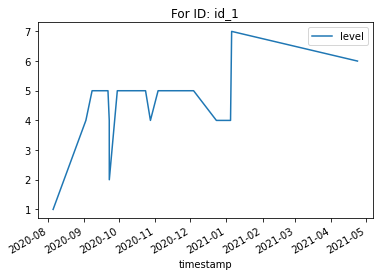

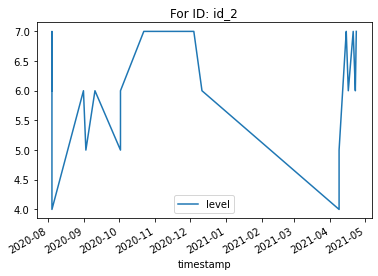

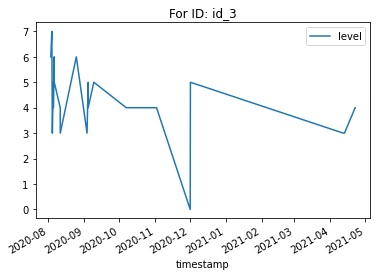

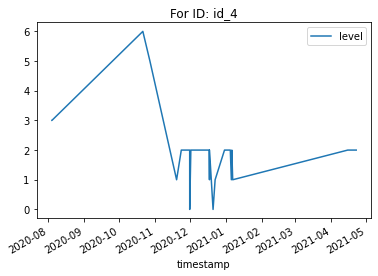

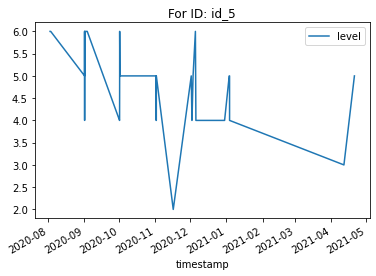

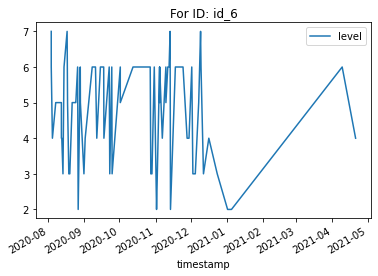

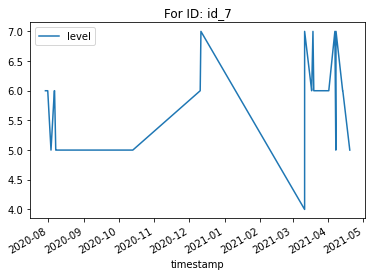

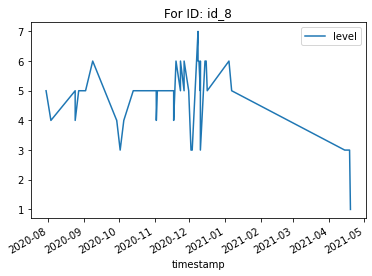

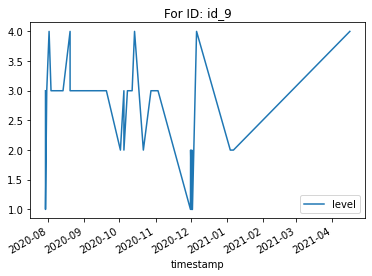

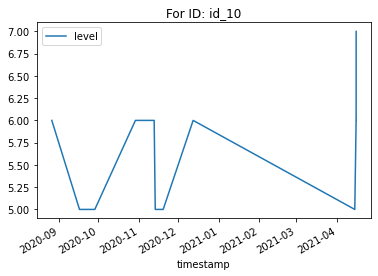

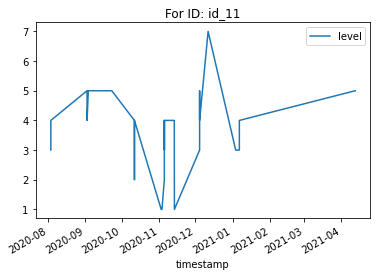

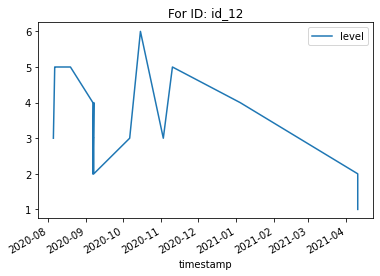

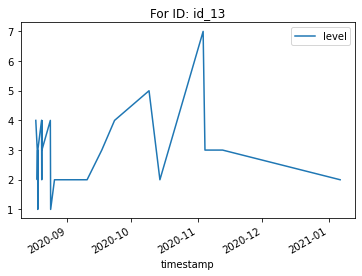

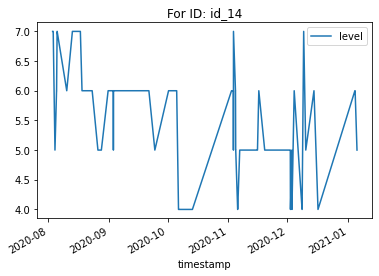

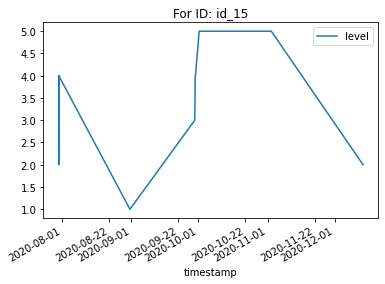

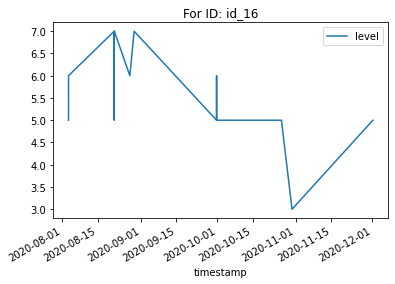

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    data_for_scode.plot(title = 'For ID: '+ str(scode))

_______________________________________________________________

**Now, we will  check if  time series is stationary or not?**

Stationarity: A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

Conditions to be stationary:-
1. Constant mean
2. Constant Variance
3. Auto-covariance that does not depend on time.

There are 2 ways to check if a time series  is stationary or not:-
1. AD-Fuller test

2. Plot graph  and check if mean/ variance does not vary with time.

## AD-Fuller Test

Generally, AD fuller test assumes that we have more than 250 data points(atleast 100 points) in a data set. But, in our data set, we have very less data poinsts for each IDs. So, we cannot rely on AD-fuller purely for this analysis.

In [ ]:
#Ho: It is non stationary
#H1: It is stationary
non_stationary = []
def adfuller_test(df, scode, add_to_non = False):
    result=adfuller(df)
    if result[1] > 0.05:
        print("Time series is non-stationary for: "+ scode)
        if add_to_non:
          non_stationary.append(scode)

Calling AD-Fuller and printing out the Non-Stationary IDs.

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    adfuller_test(data_for_scode['level'], scode, True)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_9
Time series is non-stationary for: id_10
Time series is non-stationary for: id_12
Time series is non-stationary for: id_13
Time series is non-stationary for: id_15
Time series is non-stationary for: id_16


Storing the Non-stationary IDs in a Numpy array.

In [ ]:
# non_stationary
non_stationary = np.array(non_stationary, dtype='O')

Now, we will convert the Non-Stationary IDs to Stationary using Deifferncing, we have shifted  the IDs, by 1 shift and then differenced them.

In [ ]:
for i in non_stationary:
  data_for_scode = final_data[ final_data['scode'] == i ]
  data_for_scode['Seasonal First Difference']=data_for_scode['level']-data_for_scode['level'].shift(1)
  data_for_scode.dropna(inplace =True)
  adfuller_test(data_for_scode['Seasonal First Difference'], i)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_10
Time series is non-stationary for: id_15


## Auto-corelation Plot to find the p-value

To select p-value, we draw aut-correlation plots. We select the p-value where the Auto-correlation touches or drops below the dotted line in the below graph.

                            id_1


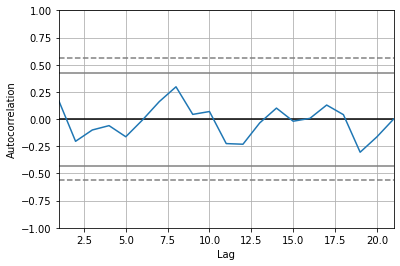

                            id_2


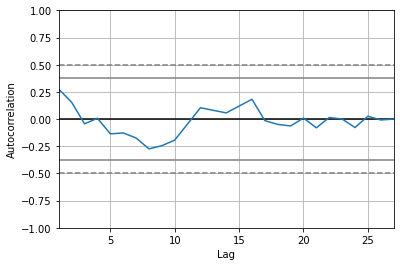

                            id_3


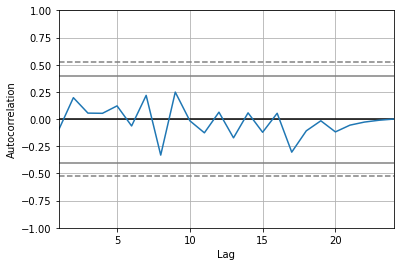

                            id_4


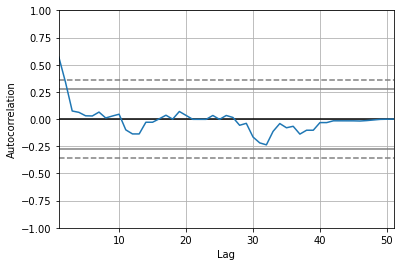

                            id_5


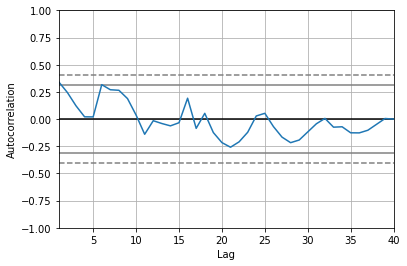

                            id_6


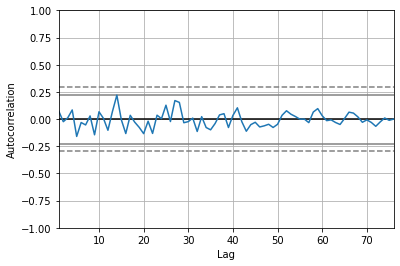

                            id_7


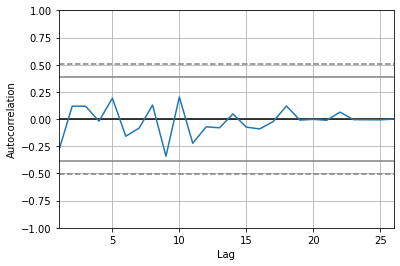

                            id_8


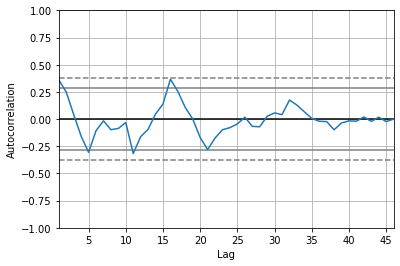

                            id_9


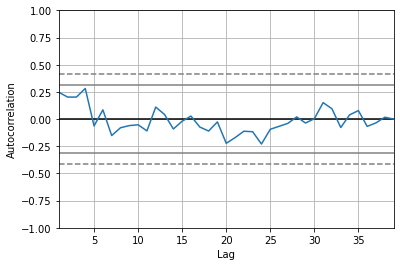

                            id_10


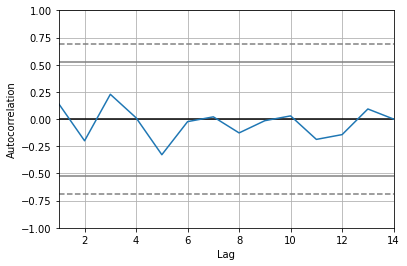

                            id_11


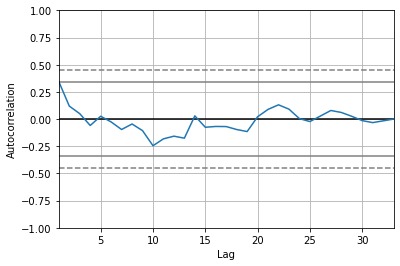

                            id_12


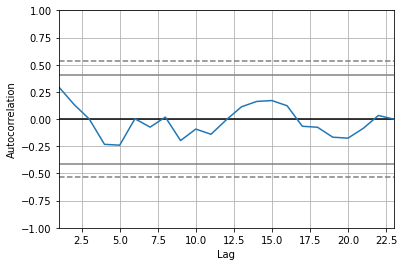

                            id_13


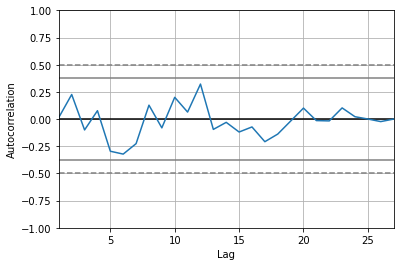

                            id_14


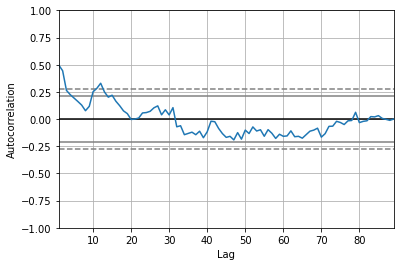

                            id_15


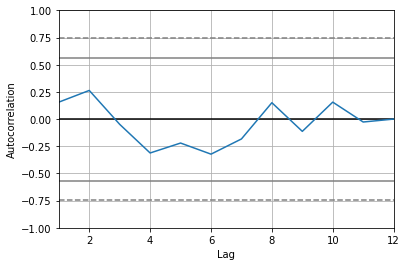

                            id_16


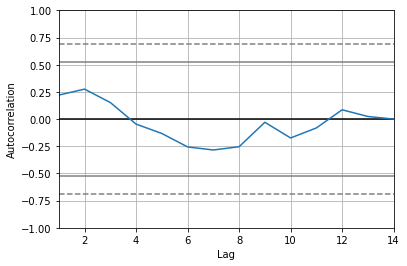

In [ ]:
#  selecting p value for each id
from pandas.plotting import autocorrelation_plot
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    print('                            '+scode)
    autocorrelation_plot(data_for_scode['level'])
    plt.show()  

In [ ]:
p_value = {'id_1': 0,
           'id_2': 0,
           'id_3': 0,
           'id_4': 1,
           'id_5': 1,
           'id_6': 0,
           'id_7': 1,
           'id_8': 0,
           'id_9': 0,
           'id_10': 0,
           'id_11': 0 ,
           'id_12': 0,
           'id_13': 0,
           'id_14': 2,
           'id_15': 0,
           'id_16': 0}

In [ ]:
# final_data
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# acf for p value of each id
# pacf for q value of each id

## PACF

We draw the Partila Auto-correlation Function graphs to find the q-value of our models.
We decide the q-value which lies outside of the blue area.

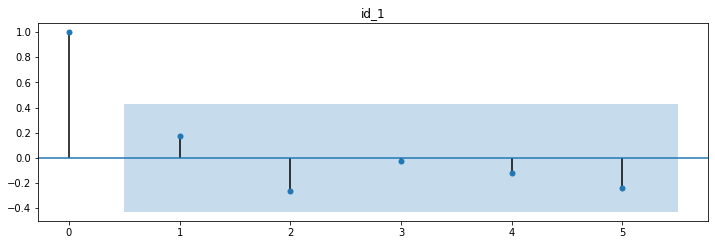

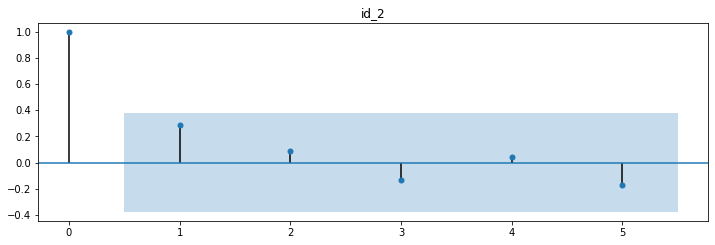

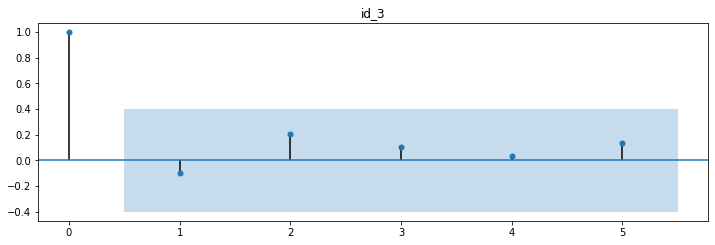

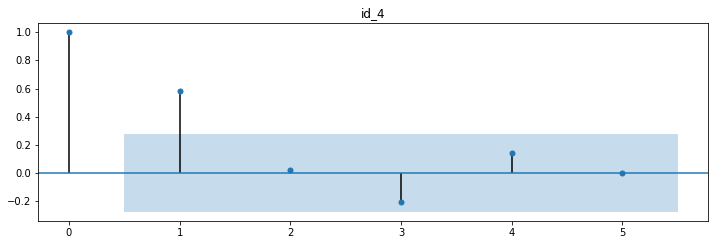

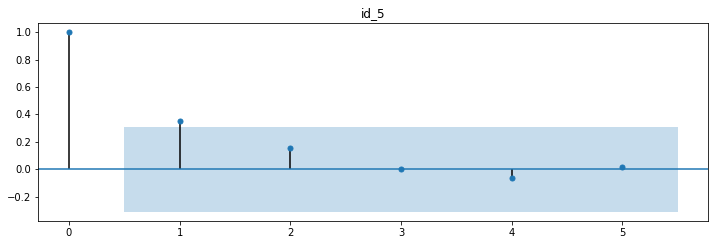

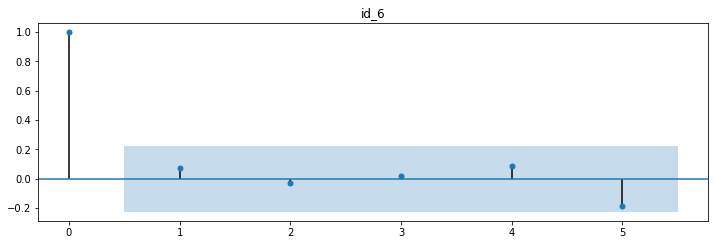

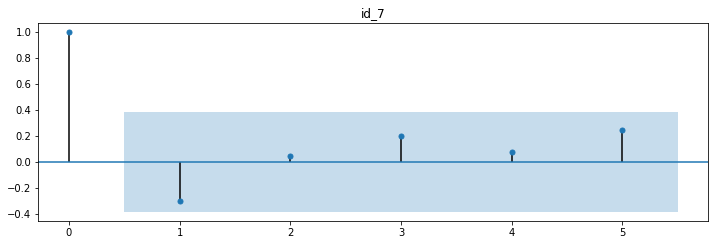

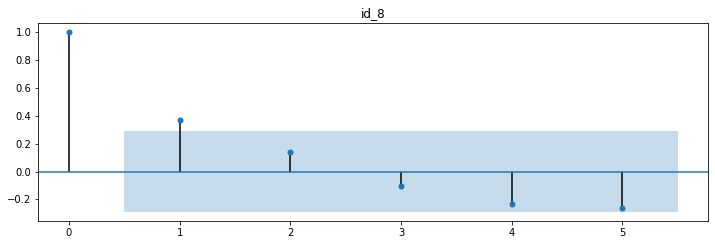

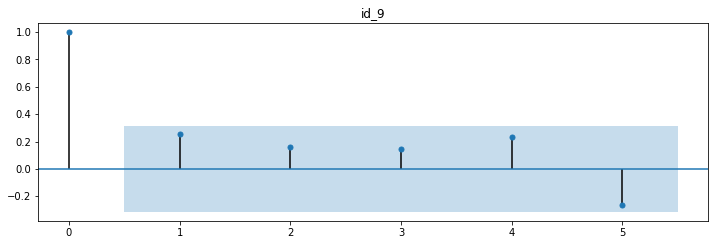

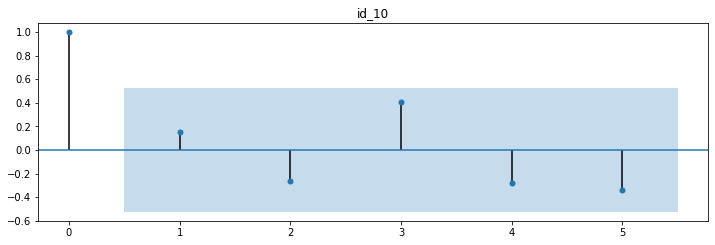

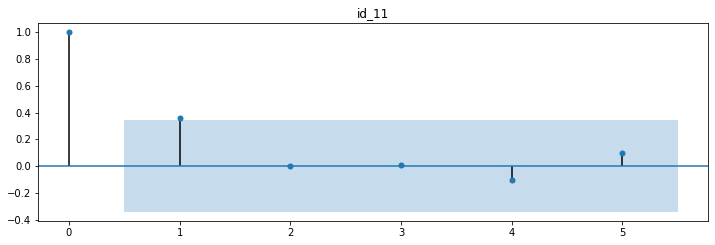

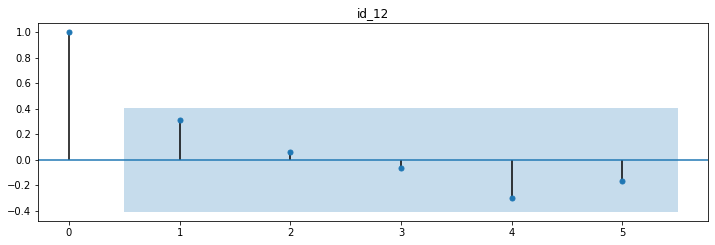

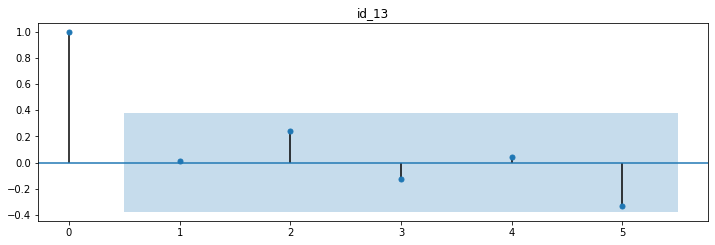

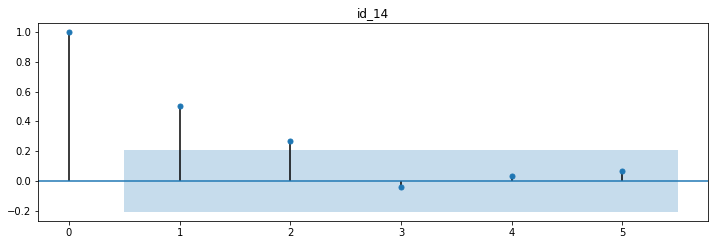

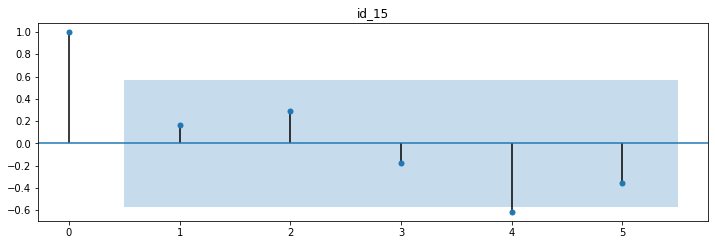

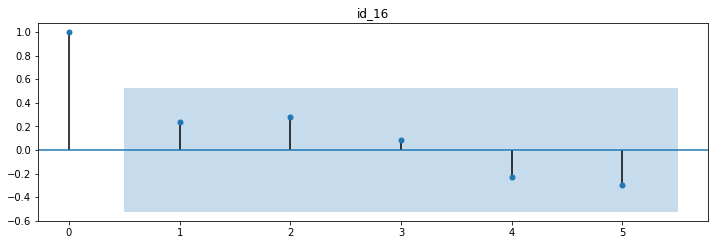

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    fig = plt.figure(figsize=(12,8))
    # ax1 = fig.add_subplot(211)
    # fig = sm.graphics.tsa.plot_acf(data_for_scode['level'],lags=10,ax=ax1, title =scode)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data_for_scode['level'],lags=5,ax=ax2, title =scode)

For all of the above graphs, we can see that Q-value can be set to 1.

In [ ]:
q = 1

Function to calculate mean RMSE and MAE.

RMSE/ RMSD formula:-
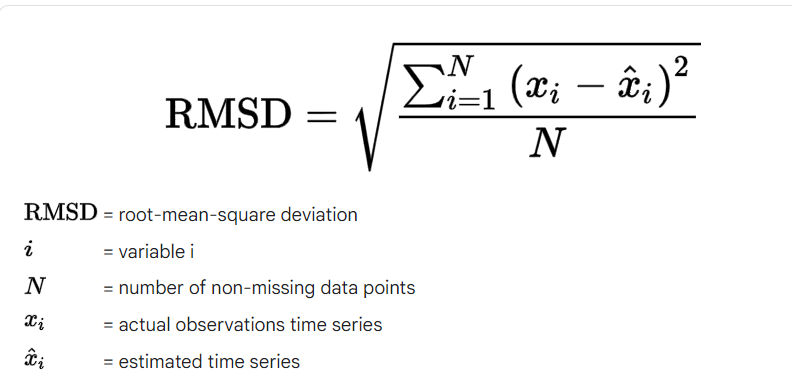


MAE formula:-
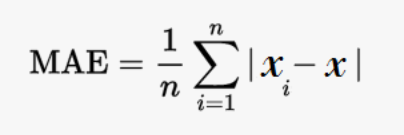

In [ ]:
def calculate_error(rmse, mae):
  mean_rmse  = sum(rmse)/ len(rmse)
  mean_mae = sum(mae)/ len(mae)
  return mean_rmse, mean_mae

## 1.ARMA

Auto-Regressive Moving Average model

In [ ]:
def calculate_ARMA():  
  arima_rmse, arima_mae = [], []
  for scode in unique_scodes:
      data_for_scode = final_data[ final_data['scode'] == scode ]
      data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
      if scode in non_stationary or scode in ['id_6']:
        continue

      model=ARIMA(data_for_scode['level'].astype(float) ,order=(0,0,0))
      model_fit=model.fit()
      data_for_scode['ARIMA_Forecast'] = model_fit.predict(start = 0, end= len(data_for_scode) +4 , dynamic = True)
      data_for_scode[['level','ARIMA_Forecast']].plot(figsize=(12,8))
      # testScore = accuracy_score(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      RMSE = mean_squared_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
      arima_rmse.append(RMSE)
      MAE = mean_absolute_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      print('MAE for '+ str(scode) + ' is: ' + str(MAE))
      arima_mae.append(MAE)
      # MAPE = mean_absolute_percentage_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      # print('MAE for '+ str(scode) + ' is: ' + str(MAPE))
  print('-----------------------------------------')
  mean_mse, mean_mae = calculate_error(arima_rmse, arima_mae)
  print('Mean RMSE is:'+ str(mean_mse))
  print('Mean MAE is: '+ str(mean_mae))
      # print('--------------------------------')
      # print('Model Summary for : ' +scode)
      # print(model_fit.summary())

Mean RMSE is:1.1306842942494422 <br>
Mean MAE is: 0.790229762589545

RMSE for id_1 is: 1.4829931972789112
MAE for id_1 is: 0.8571428571428579
RMSE for id_2 is: 0.858710562414266
MAE for id_2 is: 0.7681755829903978
RMSE for id_4 is: 1.0918877354863514
MAE for id_4 is: 0.4944252210688195
RMSE for id_5 is: 0.994375
MAE for id_5 is: 0.8187500009604468
RMSE for id_7 is: 0.5636094674556212
MAE for id_7 is: 0.5532544382727238
RMSE for id_8 is: 1.5089792060491494
MAE for id_8 is: 1.0378071833648392
RMSE for id_11 is: 1.7594123048668504
MAE for id_11 is: 1.0358126742575193
RMSE for id_14 is: 0.7855068804443882
MAE for id_14 is: 0.7564701426587558
-----------------------------------------
Mean RMSE is:1.1306842942494422
Mean MAE is: 0.790229762589545


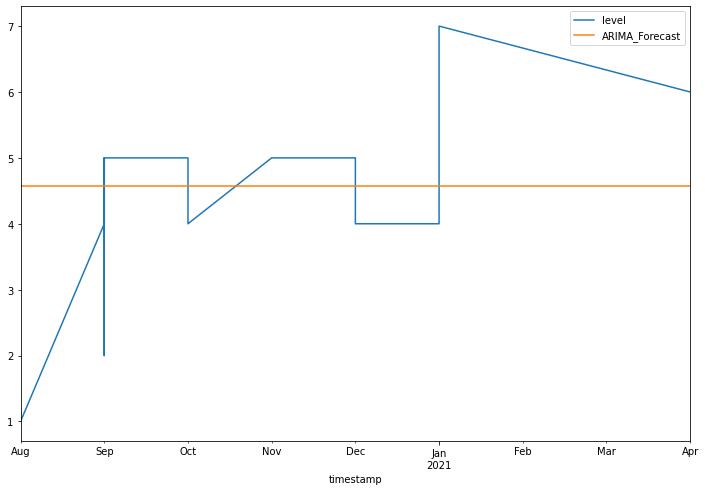

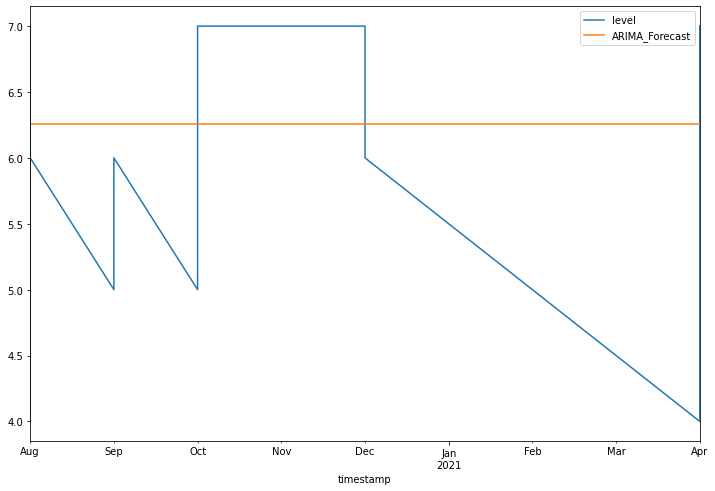

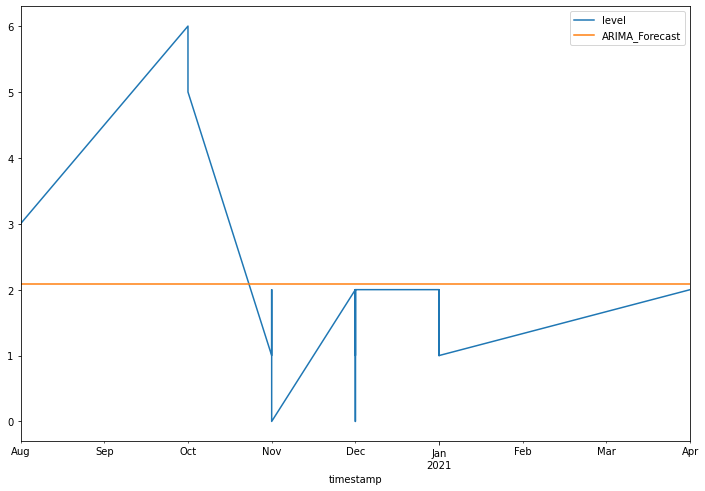

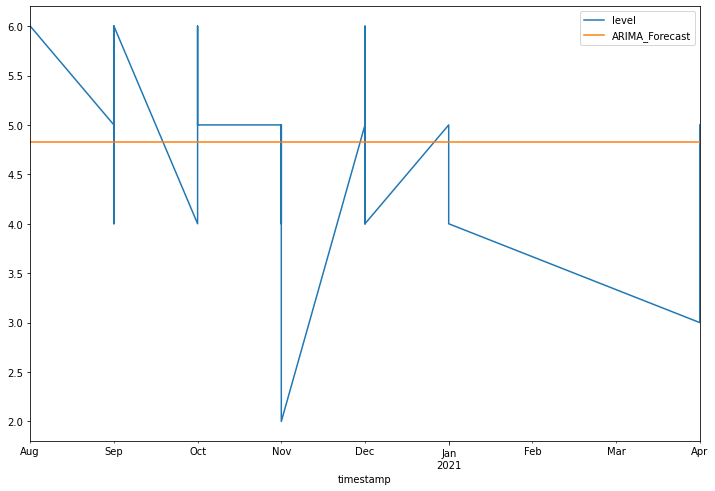

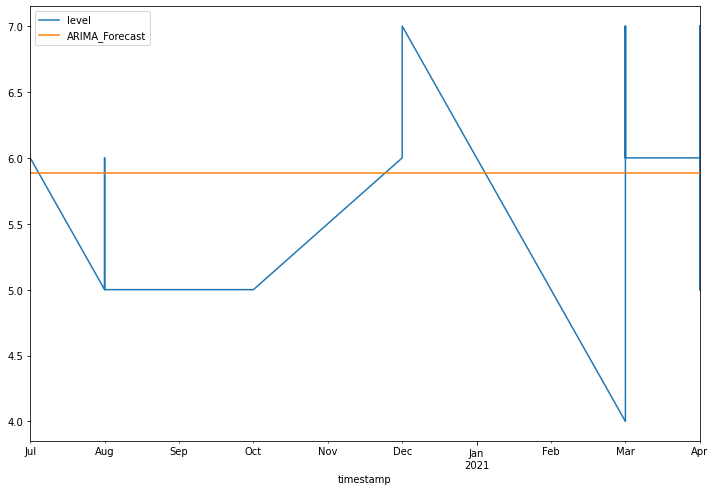

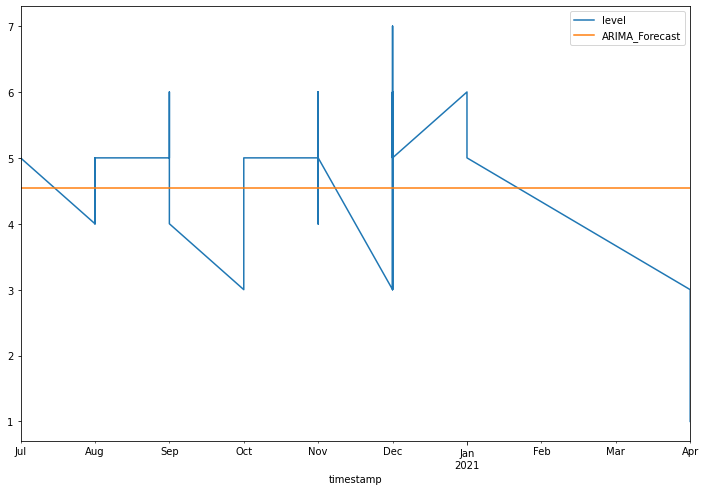

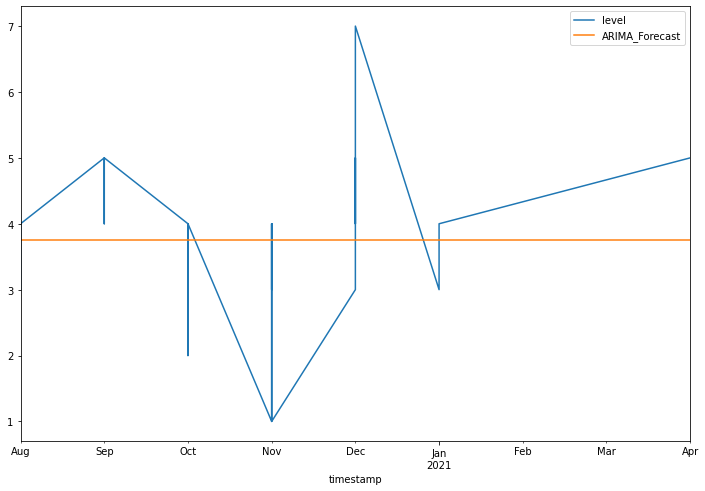

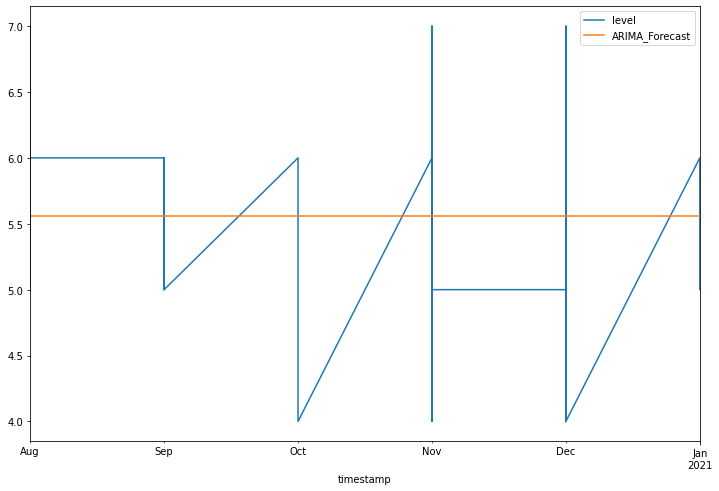

In [ ]:
calculate_ARMA()

## 2. AR Model

In [ ]:
def calculate_AR():  
  ar_rmse, ar_mae = [], []
  for scode in unique_scodes:
      data_for_scode = final_data[ final_data['scode'] == scode ]
      data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
      # if scode in non_stationary or scode in ['id_6']:
      #   continue

      model= AutoReg(data_for_scode['level'], lags=1)
      # MA(data_for_scode['level'].astype(float) ,order=(0,0,0))
      model_fit=model.fit()
      data_for_scode['AR_Forecast'] = model_fit.predict(start = 0, end= len(data_for_scode) +4 , dynamic = True)
      data_for_scode[['level','AR_Forecast']].plot(figsize=(12,8))
      data_for_scode['AR_Forecast'] = data_for_scode['AR_Forecast'].fillna(0)
      RMSE = mean_squared_error(data_for_scode['level'], data_for_scode['AR_Forecast'])
      print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
      ar_rmse.append(RMSE)
      MAE = mean_absolute_error(data_for_scode['level'], data_for_scode['AR_Forecast'])
      print('MAE for '+ str(scode) + ' is: ' + str(MAE))
      ar_mae.append(MAE)
      
  print('-----------------------------------------')
  mean_mse, mean_mae = calculate_error(ar_rmse, ar_mae)
  print('Mean RMSE is:'+ str(mean_mse))
  print('Mean MAE is: '+ str(mean_mae))
      # print('--------------------------------')
      # print('Model Summary for : ' +scode)
      # print(model_fit.summary())

Mean RMSE is:5.964679295593076 <br>
Mean MAE is: 1.6261446609532142

RMSE for id_1 is: 0.898568808270814
MAE for id_1 is: 0.7683704295257033
RMSE for id_2 is: 5.707401693406319
MAE for id_2 is: 1.481795366902926
RMSE for id_3 is: 12.810953778688024
MAE for id_3 is: 2.7629740416410864
RMSE for id_4 is: 1.3410630941875799
MAE for id_4 is: 0.6088192932540304
RMSE for id_5 is: 4.355838883128152
MAE for id_5 is: 1.2525323483357718
RMSE for id_6 is: 8.206792081404744
MAE for id_6 is: 2.2598207685093135
RMSE for id_7 is: 4.709718938292687
MAE for id_7 is: 1.2291945680827472
RMSE for id_8 is: 2.049353469058104
MAE for id_8 is: 1.144788705337146
RMSE for id_9 is: 1.2764117017675007
MAE for id_9 is: 0.8744583981102986
RMSE for id_10 is: 2.949089546718935
MAE for id_10 is: 0.9646850733349562
RMSE for id_11 is: 2.8677047790597268
MAE for id_11 is: 1.3310673672555942
RMSE for id_12 is: 5.82300679992093
MAE for id_12 is: 1.7345017282982593
RMSE for id_13 is: 5.849372580013081
MAE for id_13 is: 2.0434901952293503
RMSE for id_14 is: 8.730364116588223
MAE for id_14 is: 

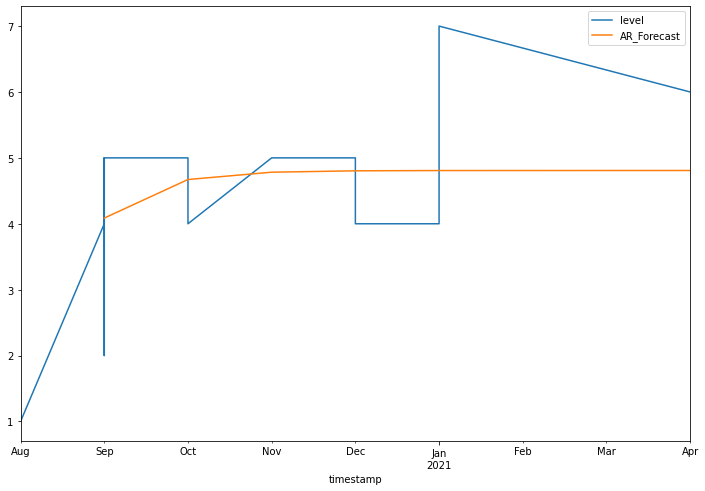

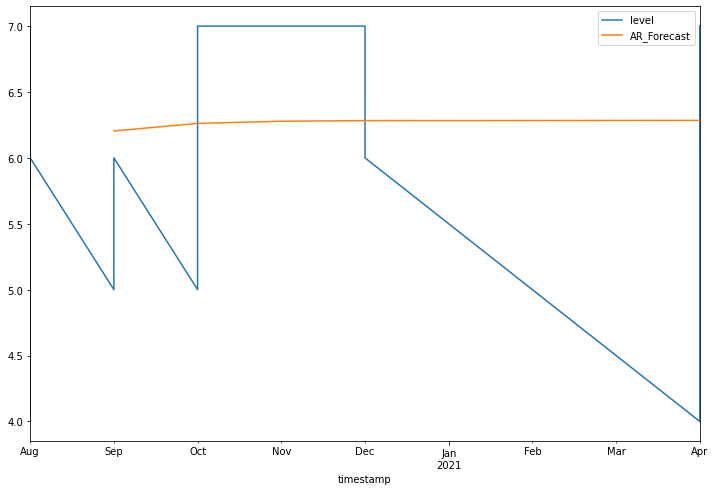

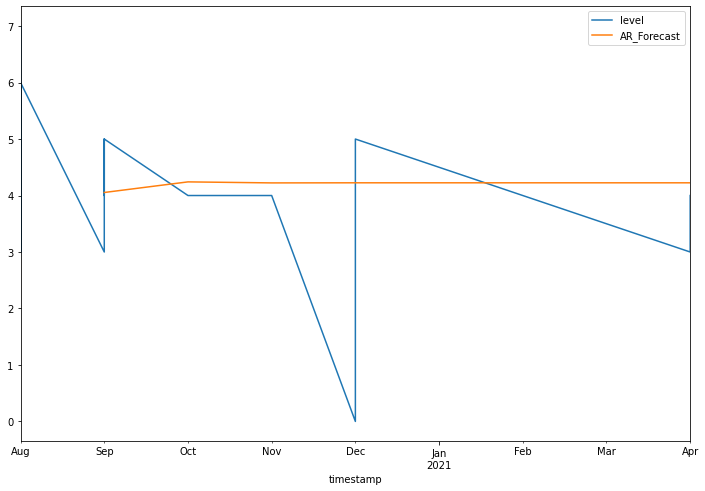

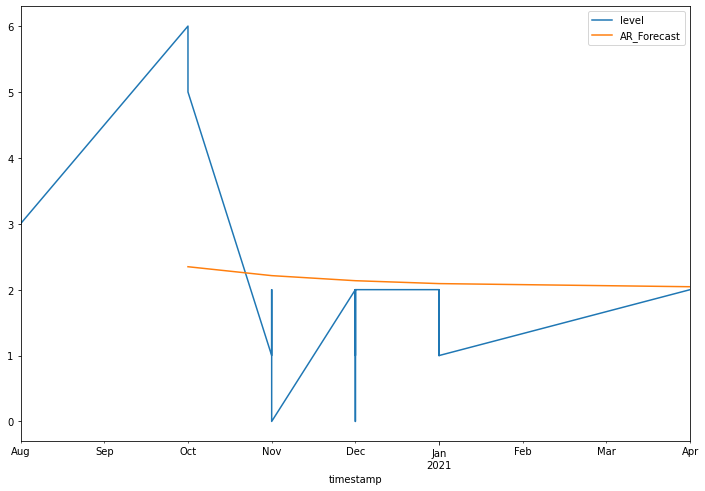

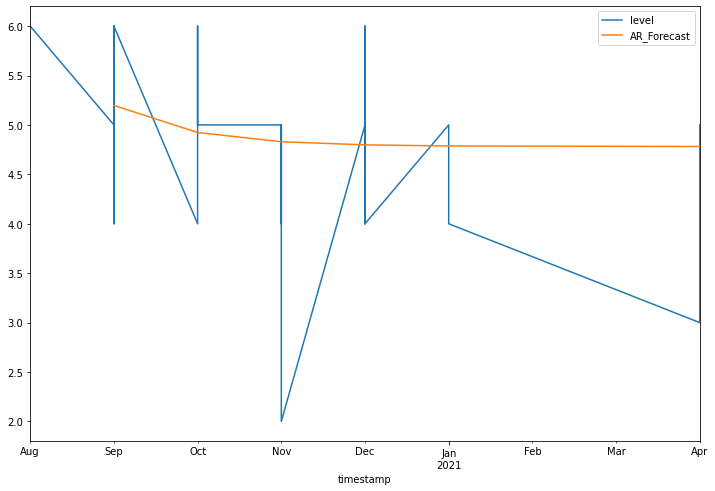

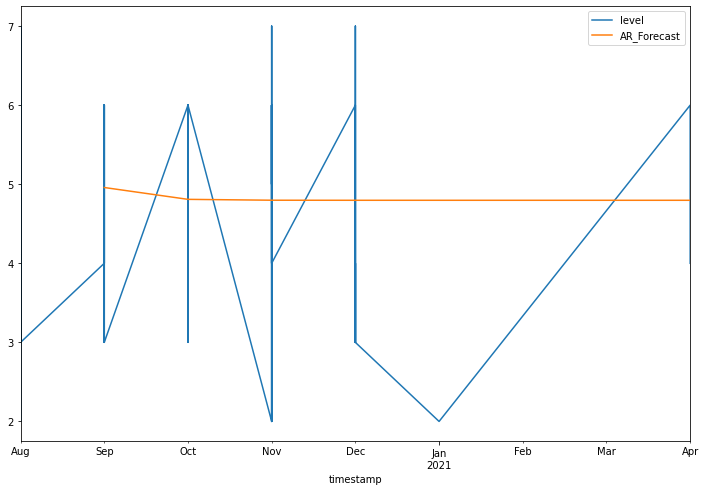

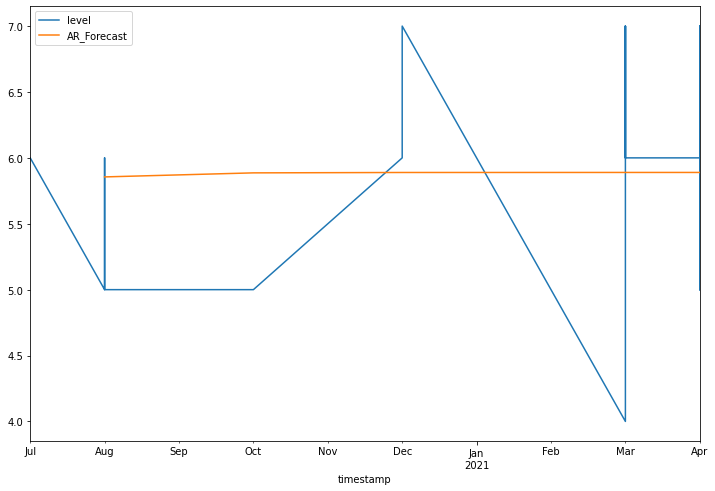

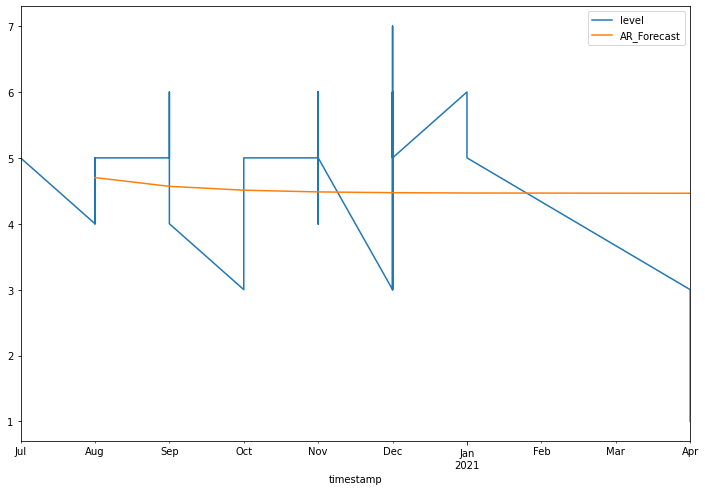

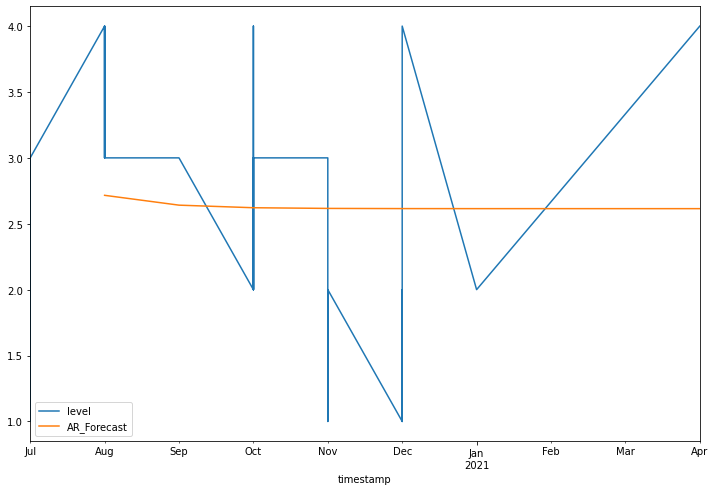

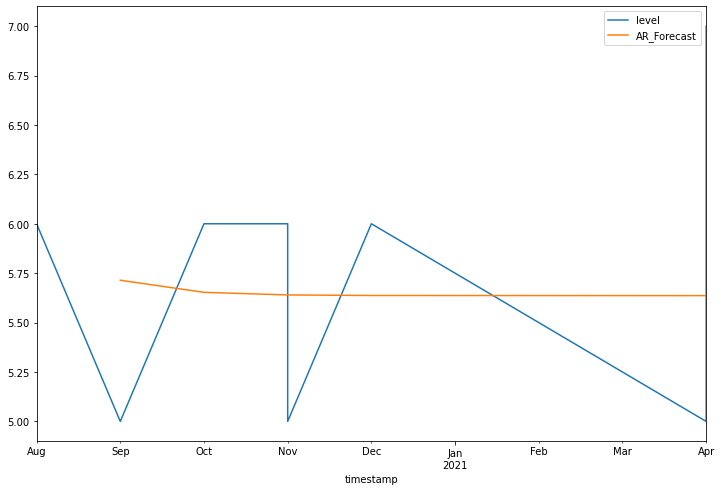

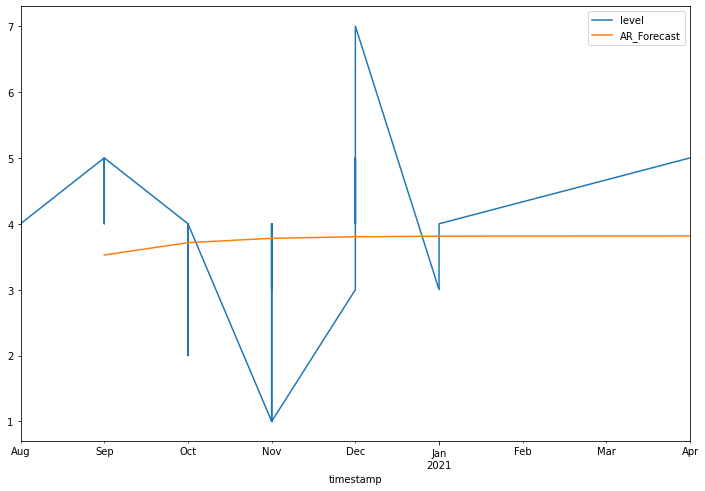

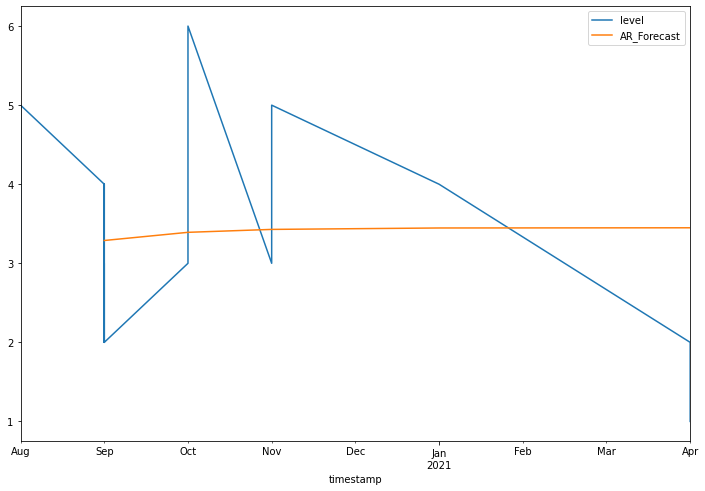

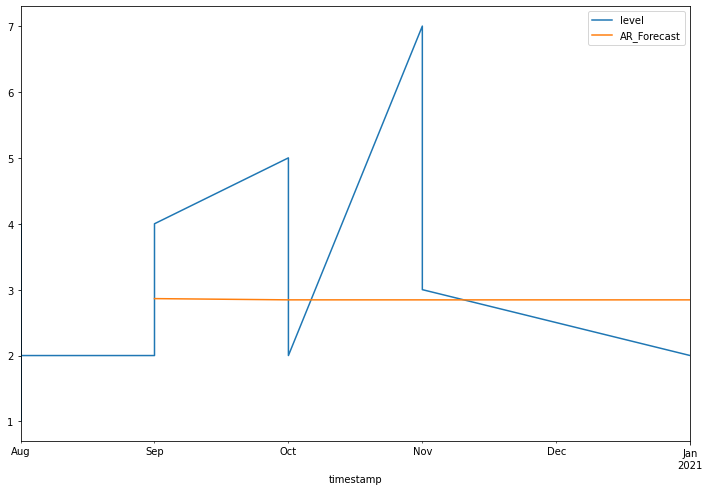

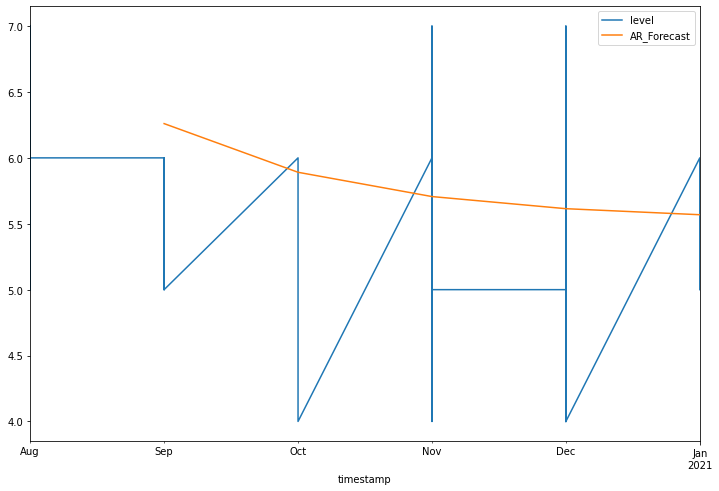

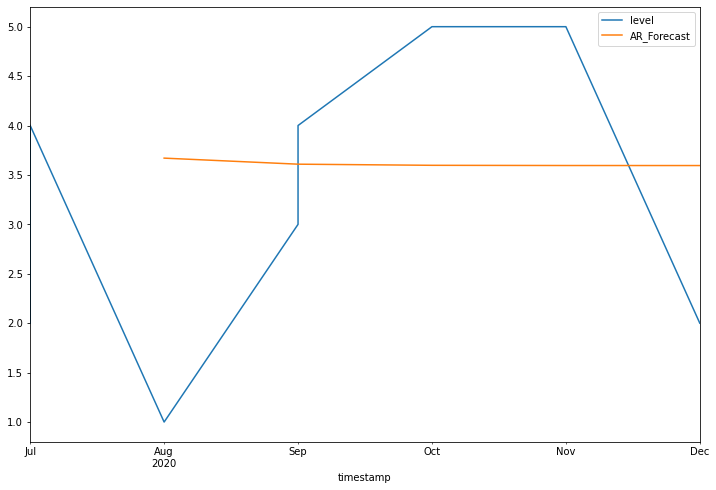

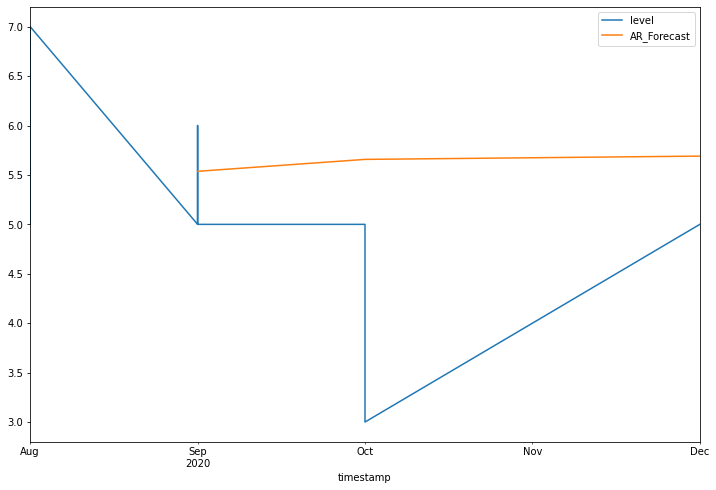

In [ ]:
calculate_AR()

## 3. MA Model

In [ ]:
def calculate_MA():
  ma_rmse, ma_mae = [], []
  for scode in unique_scodes:
      data_for_scode = final_data[ final_data['scode'] == scode ]
      data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
      # if scode in non_stationary or scode in ['id_6']:
      #   continue

      model = ARIMA(data_for_scode['level'].astype(float), order=(0, 0, 1))
      # MA(data_for_scode['level'].astype(float) ,order=(0,0,0))
      model_fit=model.fit()
      data_for_scode['MA_Forecast'] = model_fit.predict(start = 0, end= len(data_for_scode) +4 , dynamic = True)
      data_for_scode[['level','MA_Forecast']].plot(figsize=(12,8))
      data_for_scode['AR_Forecast'] = data_for_scode['MA_Forecast'].fillna(0)
      RMSE = mean_squared_error(data_for_scode['level'], data_for_scode['MA_Forecast'])
      print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
      ma_rmse.append(RMSE)
      MAE = mean_absolute_error(data_for_scode['level'], data_for_scode['MA_Forecast'])
      print('MAE for '+ str(scode) + ' is: ' + str(MAE))
      ma_mae.append(MAE)
      
  print('-----------------------------------------')
  mean_mse, mean_mae = calculate_error(ma_rmse, ma_mae)
  print('Mean RMSE is:'+ str(mean_mse))
  print('Mean MAE is: '+ str(mean_mae))
      # print('--------------------------------')
      # print('Model Summary for : ' +scode)
      # print(model_fit.summary())

Mean RMSE is:1.3119476127984138 <br>
Mean MAE is: 0.8891765523824912

RMSE for id_1 is: 1.5378805239278368
MAE for id_1 is: 0.8844767824547949
RMSE for id_2 is: 0.8882986861095903
MAE for id_2 is: 0.7805297262861175
RMSE for id_3 is: 1.9440140212327595
MAE for id_3 is: 1.062764210973823
RMSE for id_4 is: 1.093787612832507
MAE for id_4 is: 0.5018204065024089
RMSE for id_5 is: 0.9639573897140498
MAE for id_5 is: 0.8024648375332118
RMSE for id_6 is: 2.0859443057649516
MAE for id_6 is: 1.268773366944579
RMSE for id_7 is: 0.5631889217892977
MAE for id_7 is: 0.5479430431521848
RMSE for id_8 is: 1.5485570485625644
MAE for id_8 is: 1.0606336411436916
RMSE for id_9 is: 0.8322969536329845
MAE for id_9 is: 0.7467547001101441
RMSE for id_10 is: 0.43807510814772843
MAE for id_10 is: 0.5860969366137605
RMSE for id_11 is: 1.7877502136113694
MAE for id_11 is: 1.0454853811989582
RMSE for id_12 is: 1.9137477580068194
MAE for id_12 is: 1.14365044289808
RMSE for id_13 is: 1.5780433681831199
MAE for id_13 is: 0.9389619920916931
RMSE for id_14 is: 0.8582597683071083
MAE for i

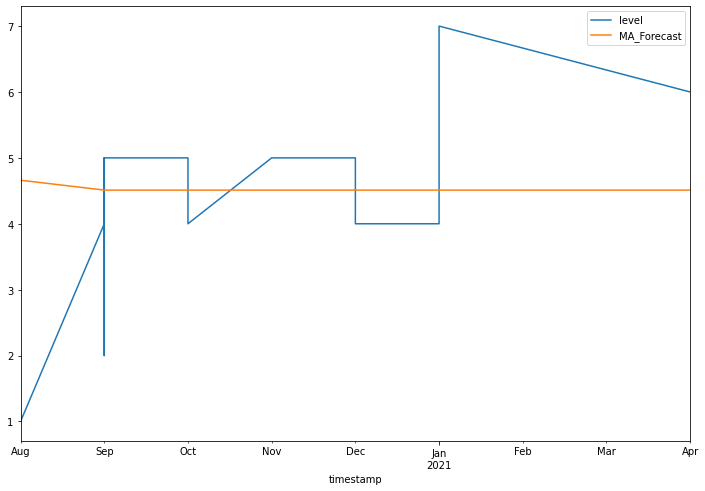

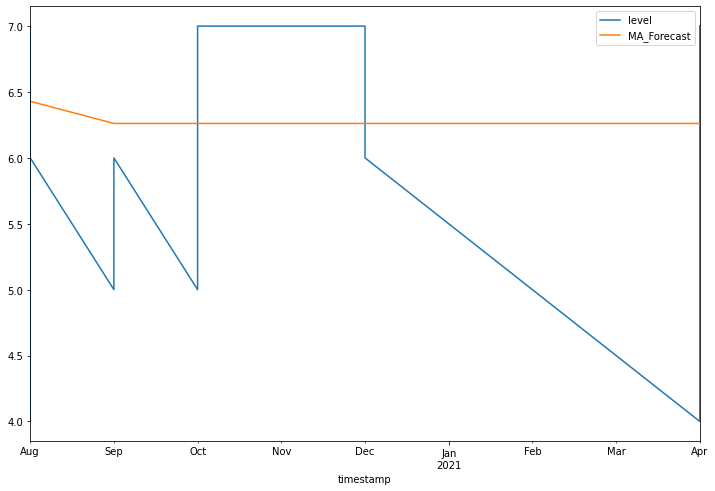

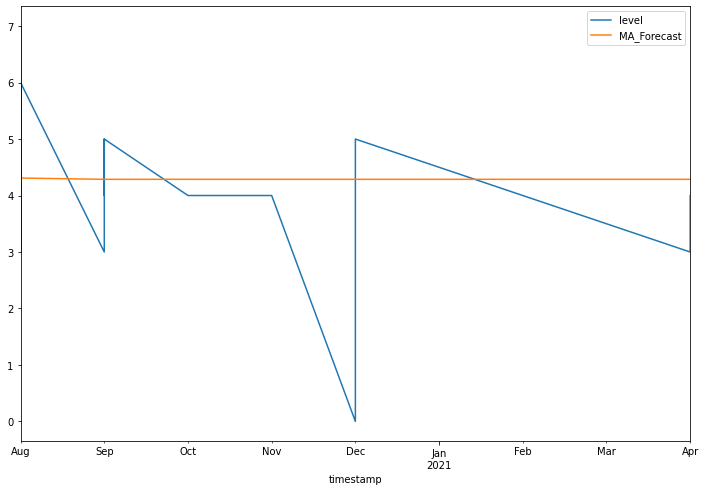

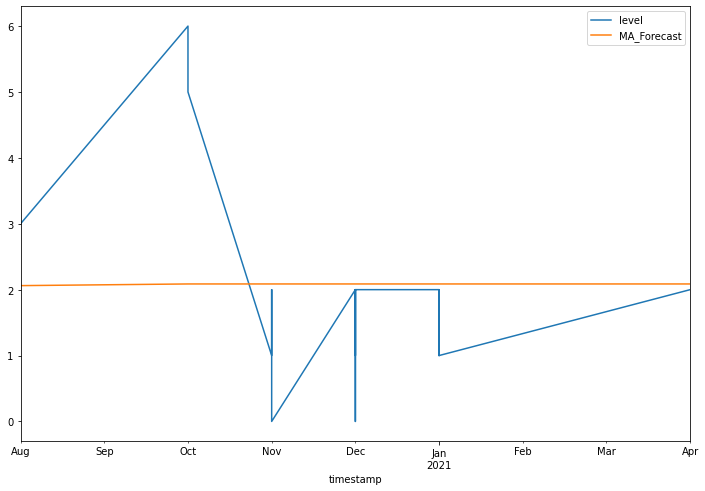

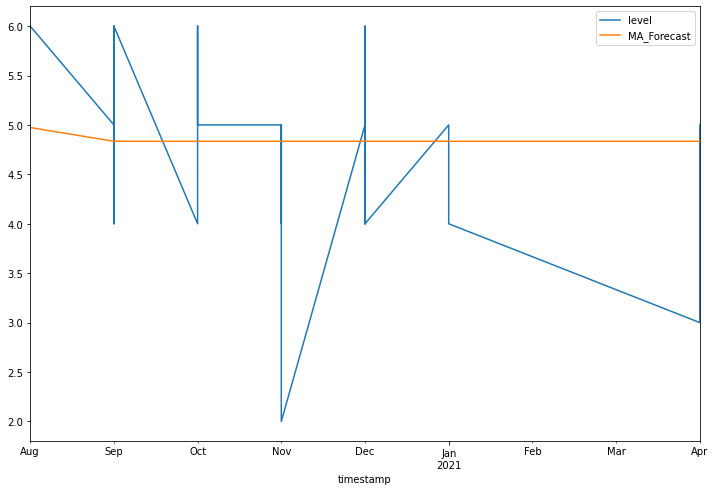

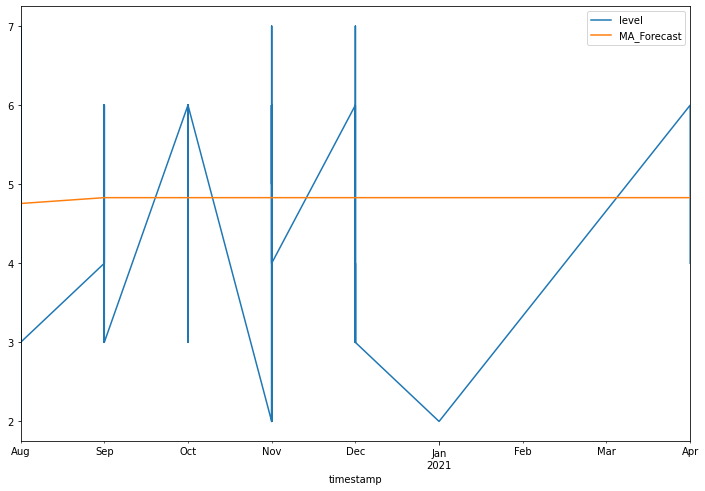

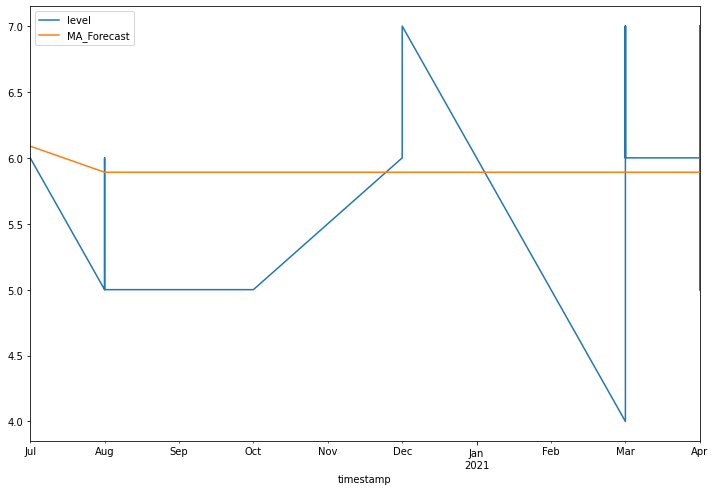

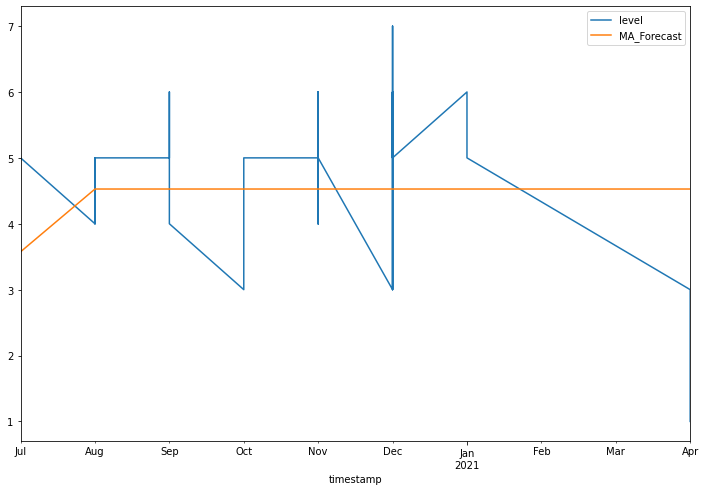

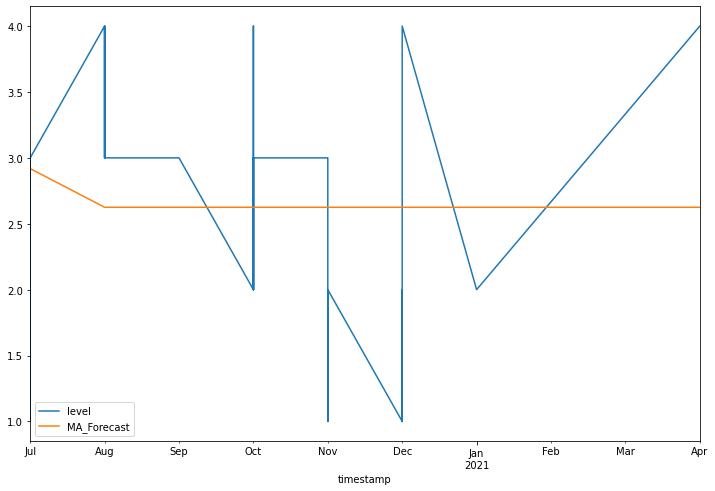

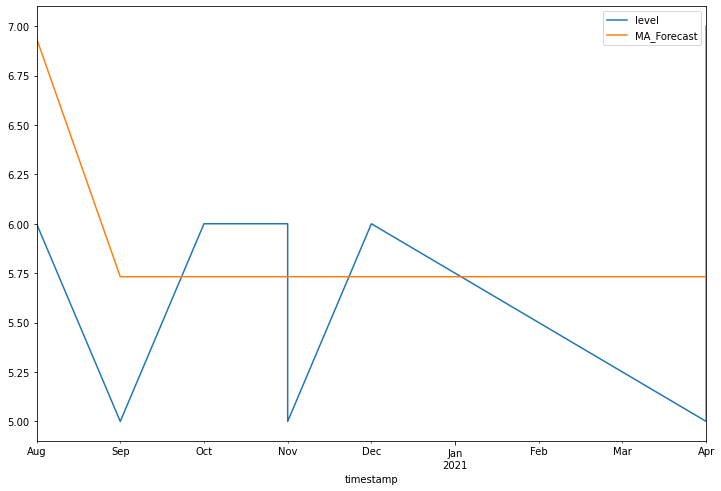

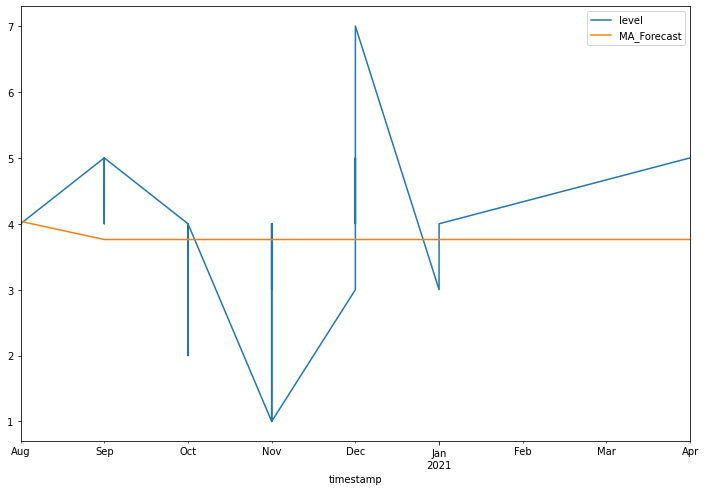

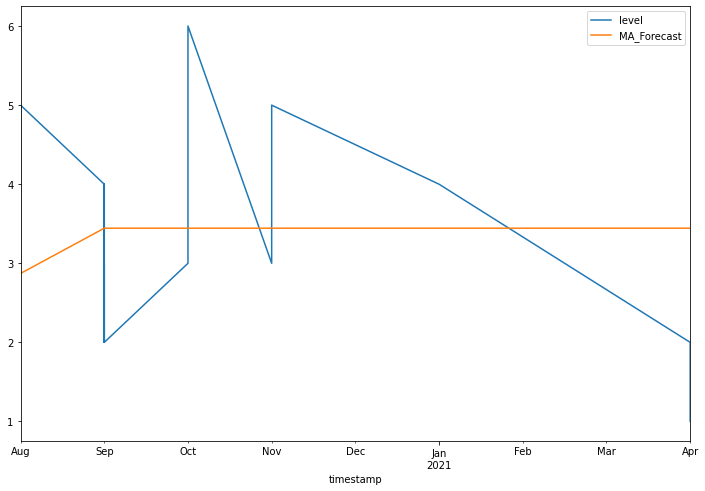

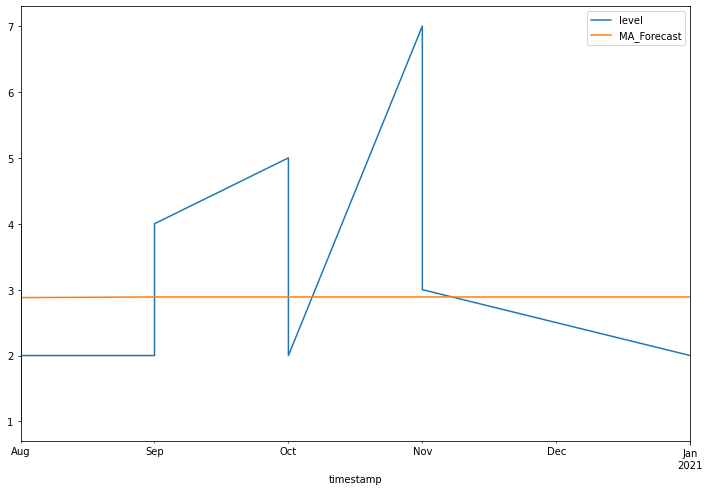

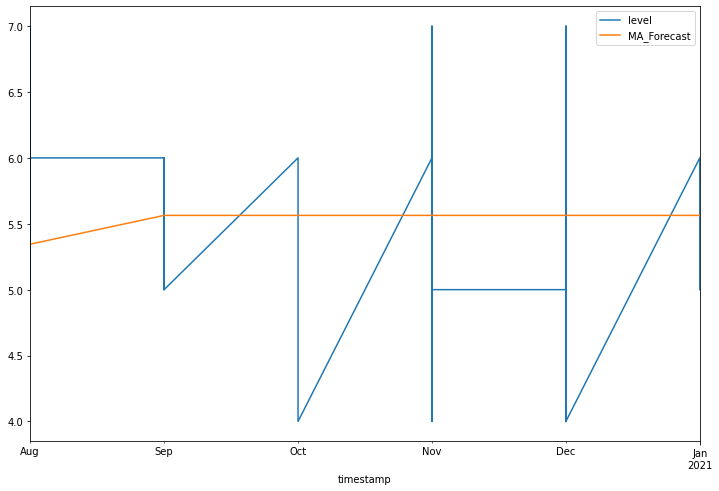

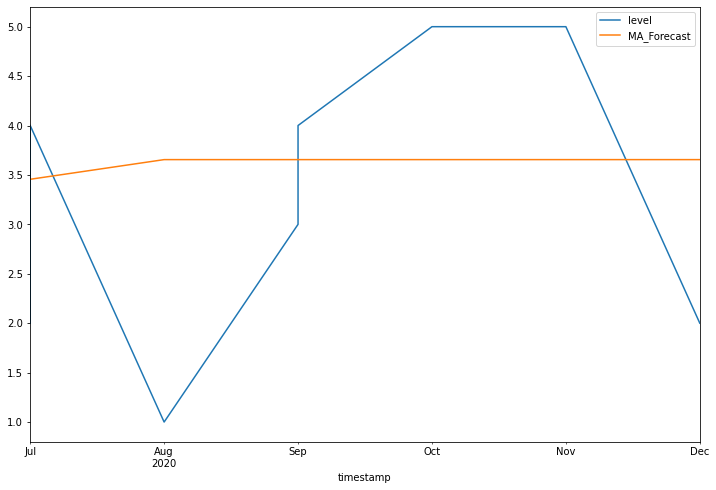

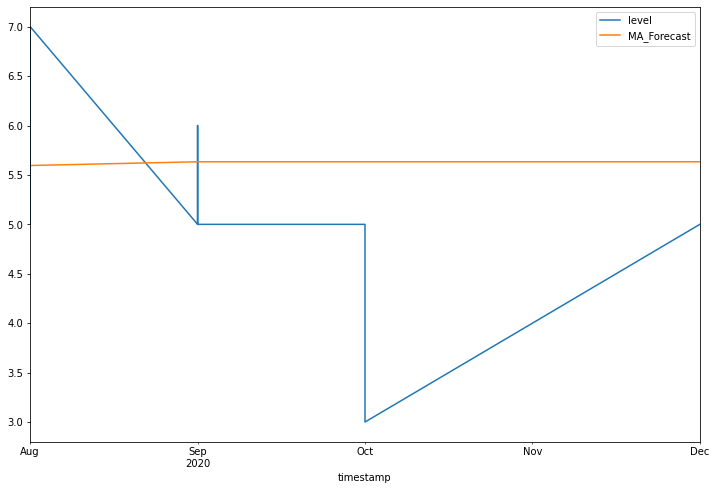

In [ ]:
calculate_MA()

## 4. ARIMAX 

In [ ]:
def calculate_arimax():
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in final_data['scode'].unique():
        input_data = final_data[ final_data['scode'] == session ]
        actual_series = list( input_data['level'].astype(int) )
        sarimax = sm.tsa.statespace.SARIMAX(actual_series, seasonal_order=(0,0,0,0), enforce_stationarity=False).fit()
        predicted_series = [ int(np.around(x)) for x in sarimax.predict() ]

        testScore = accuracy_score(actual_series, predicted_series)
        print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data.index)
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_arimax()

For id:  id_1  accuracy is :  0.47619047619047616
For id:  id_2  accuracy is :  0.37037037037037035
For id:  id_3  accuracy is :  0.2916666666666667
For id:  id_4  accuracy is :  0.6862745098039216
For id:  id_5  accuracy is :  0.475
For id:  id_6  accuracy is :  0.21052631578947367
For id:  id_7  accuracy is :  0.38461538461538464
For id:  id_8  accuracy is :  0.32608695652173914
For id:  id_9  accuracy is :  0.41025641025641024
For id:  id_10  accuracy is :  0.42857142857142855
For id:  id_11  accuracy is :  0.36363636363636365
For id:  id_12  accuracy is :  0.2608695652173913
For id:  id_13  accuracy is :  0.2962962962962963
For id:  id_14  accuracy is :  0.6179775280898876
For id:  id_15  accuracy is :  0.08333333333333333
For id:  id_16  accuracy is :  0.14285714285714285


In [ ]:
def plot_curves(timestamps, actual_values, predicted_values):
    for session in actual_values.keys():
        
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        fig.suptitle('For session : ' + str(session))
        
        ts = timestamps[session]
        av = actual_values[session]
        pv = predicted_values[session]
        ax.plot(ts, av, label='Actual')
        ax.plot(ts, pv, label='Predicted')
        ax.set_ylim([0.5,7.5])
        ax.legend()
        
        plt.show()

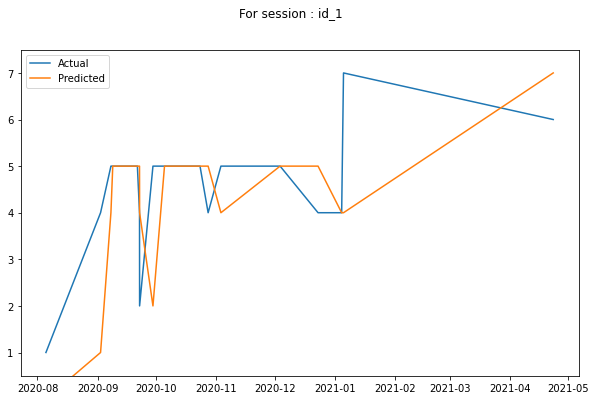

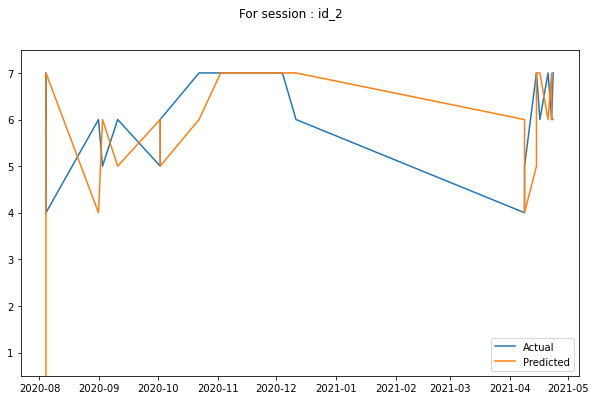

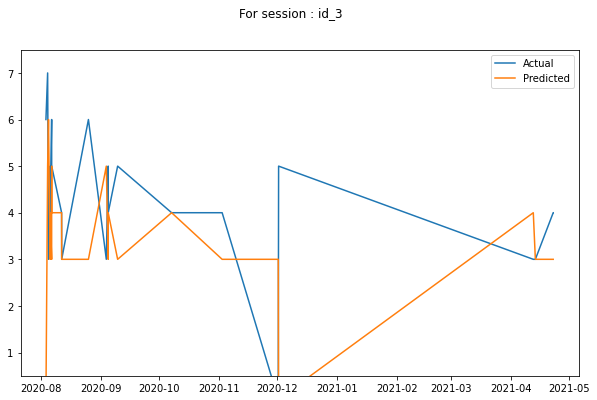

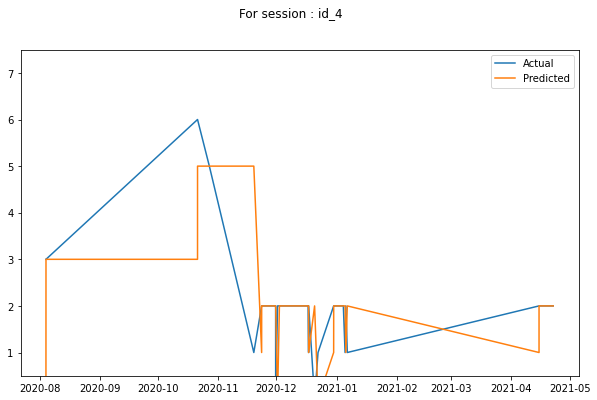

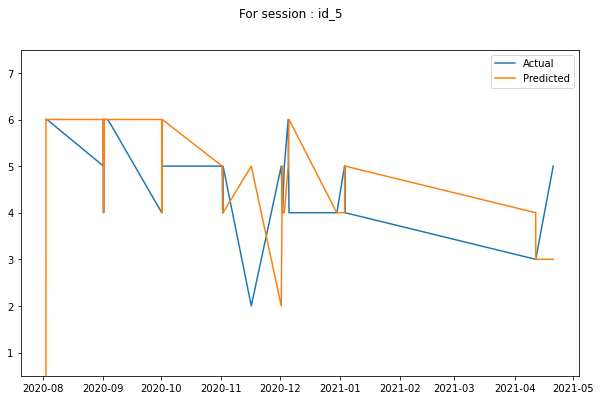

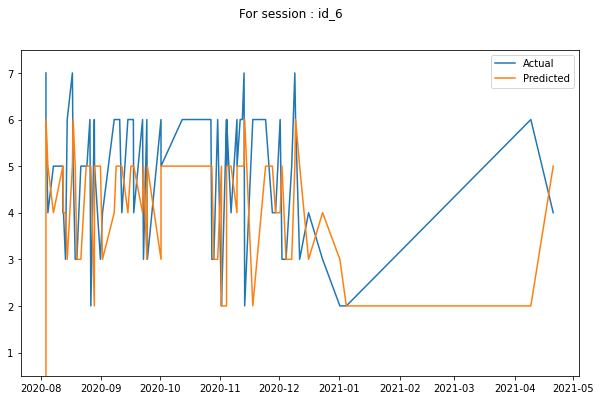

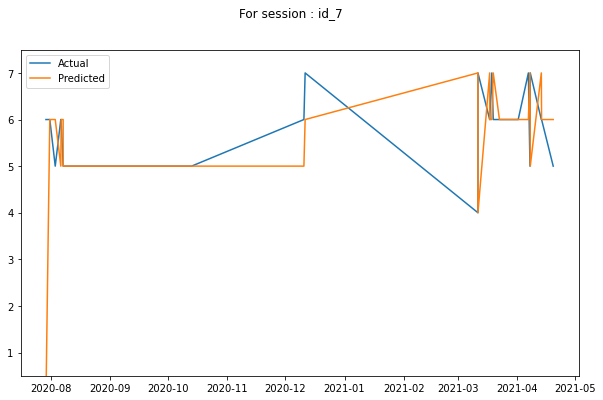

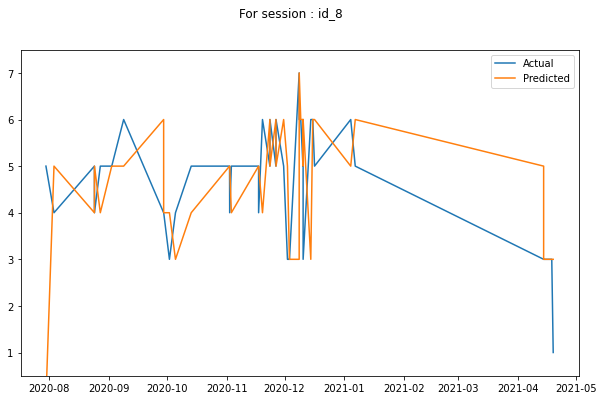

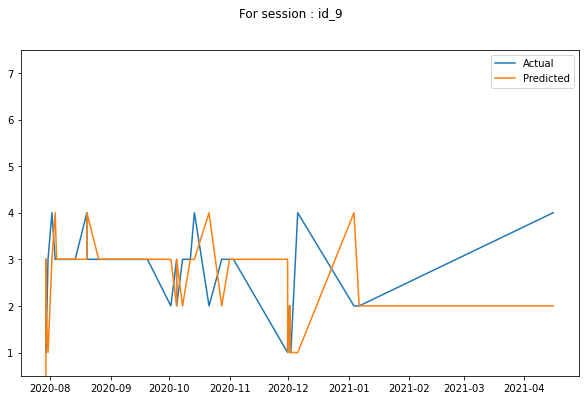

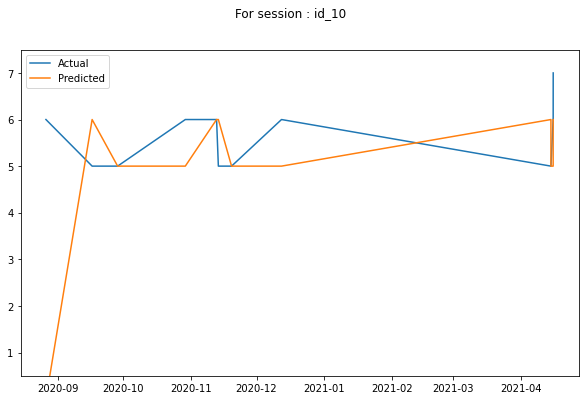

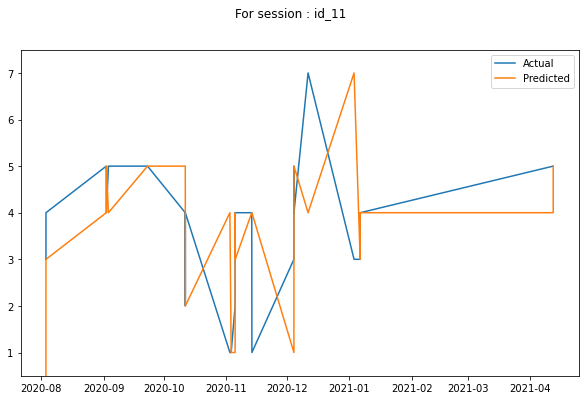

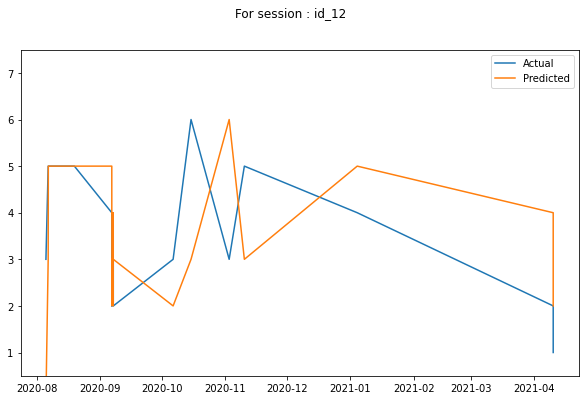

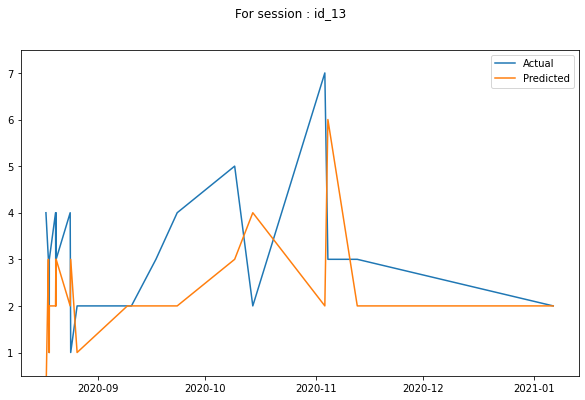

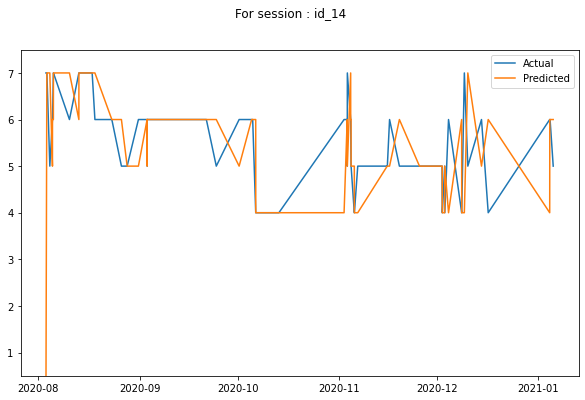

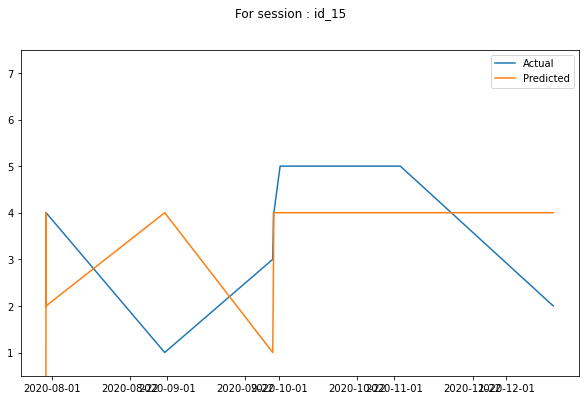

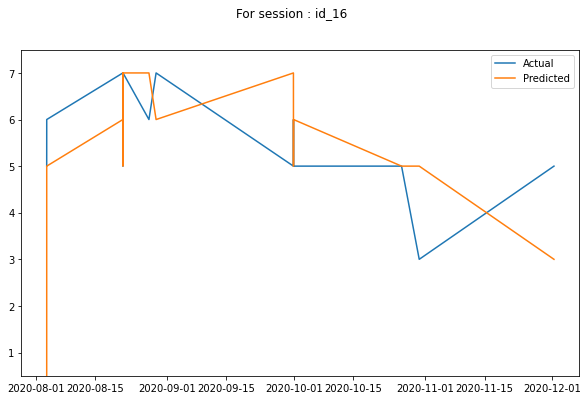

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

In [ ]:
print('Average accuracy via ARIMAX is : ', sum(accuracies)/len(accuracies))

Average accuracy via ARIMAX is :  0.3640330467635179


## 5. SARIMAX


In [ ]:
def calculate_sarimax(seasonality, log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    sm_rmse, sm_mae = [] , []
    
    for session in final_data['scode'].unique():
        input_data = final_data[ final_data['scode'] == session ]
        actual_series = list( input_data['level'].astype(int) )
        
        sarimax = sm.tsa.statespace.SARIMAX(actual_series, seasonal_order=(1,0,0,seasonality), enforce_stationarity=False).fit()
        predicted_series = [ int(np.around(x)) for x in sarimax.predict() ]
            
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data.index)
        RMSE = mean_squared_error(actual_series, predicted_series)
        print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
        sm_rmse.append(RMSE)
        MAE = mean_absolute_error(actual_series, predicted_series)
        print('MAE for '+ str(scode) + ' is: ' + str(MAE))
        sm_mae.append(MAE)

    print('-----------------------------------------')
    mean_mse, mean_mae = calculate_error(sm_rmse, sm_mae)
    print('Mean RMSE is:'+ str(mean_mse))
    print('Mean MAE is: '+ str(mean_mae))
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
max_accuracy = -1
seasonality_max = -1
for seasonality in [2,3,4,5,6]:
    accuracies, timestamps, actual_values, predicted_values = calculate_sarimax(2, log=False)
    avg_acc = sum(accuracies)/len(accuracies)
    if max_accuracy < avg_acc:
        max_accuracy = avg_acc
        seasonality_max = seasonality
print('Maximum average accuracy of {} with seasonality as {}'.format(max_accuracy, seasonality_max))

RMSE for id_16 is: 3.0476190476190474
MAE for id_16 is: 1.2380952380952381
RMSE for id_16 is: 2.5555555555555554
MAE for id_16 is: 1.0
RMSE for id_16 is: 5.916666666666667
MAE for id_16 is: 1.6666666666666667
RMSE for id_16 is: 0.9607843137254902
MAE for id_16 is: 0.49019607843137253
RMSE for id_16 is: 2.175
MAE for id_16 is: 0.875
RMSE for id_16 is: 4.184210526315789
MAE for id_16 is: 1.4736842105263157
RMSE for id_16 is: 4.230769230769231
MAE for id_16 is: 1.2307692307692308
RMSE for id_16 is: 2.217391304347826
MAE for id_16 is: 1.0434782608695652
RMSE for id_16 is: 1.5384615384615385
MAE for id_16 is: 0.8205128205128205
RMSE for id_16 is: 4.071428571428571
MAE for id_16 is: 1.0714285714285714
RMSE for id_16 is: 2.515151515151515
MAE for id_16 is: 1.121212121212121
RMSE for id_16 is: 2.260869565217391
MAE for id_16 is: 1.0434782608695652
RMSE for id_16 is: 2.888888888888889
MAE for id_16 is: 1.4074074074074074
RMSE for id_16 is: 1.3258426966292134
MAE for id_16 is: 0.5842696629213483

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_sarimax(2)

For id:  id_1  accuracy is :  0.3333333333333333
RMSE for id_16 is: 3.0476190476190474
MAE for id_16 is: 1.2380952380952381
For id:  id_2  accuracy is :  0.37037037037037035
RMSE for id_16 is: 2.5555555555555554
MAE for id_16 is: 1.0
For id:  id_3  accuracy is :  0.25
RMSE for id_16 is: 5.916666666666667
MAE for id_16 is: 1.6666666666666667
For id:  id_4  accuracy is :  0.6862745098039216
RMSE for id_16 is: 0.9607843137254902
MAE for id_16 is: 0.49019607843137253
For id:  id_5  accuracy is :  0.475
RMSE for id_16 is: 2.175
MAE for id_16 is: 0.875
For id:  id_6  accuracy is :  0.3026315789473684
RMSE for id_16 is: 4.184210526315789
MAE for id_16 is: 1.4736842105263157
For id:  id_7  accuracy is :  0.3076923076923077
RMSE for id_16 is: 4.230769230769231
MAE for id_16 is: 1.2307692307692308
For id:  id_8  accuracy is :  0.30434782608695654
RMSE for id_16 is: 2.217391304347826
MAE for id_16 is: 1.0434782608695652
For id:  id_9  accuracy is :  0.46153846153846156
RMSE for id_16 is: 1.538461

In [ ]:
print('Average accuracy via SARIMAX is : ', sum(accuracies)/len(accuracies))

Average accuracy via SARIMAX is :  0.3854803429427308


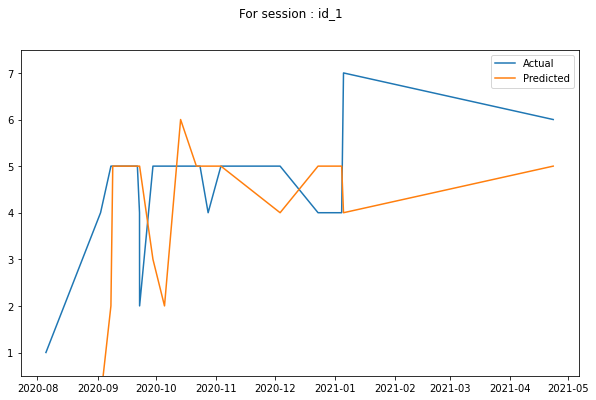

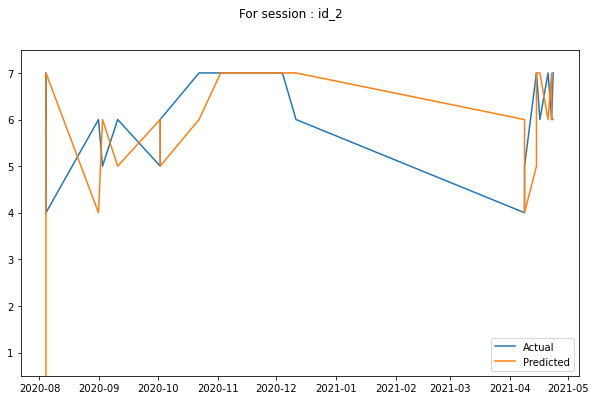

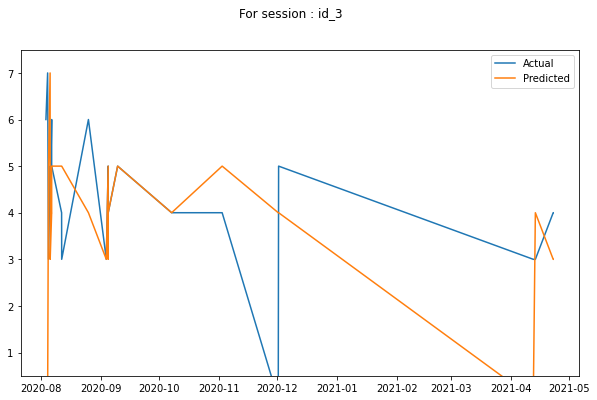

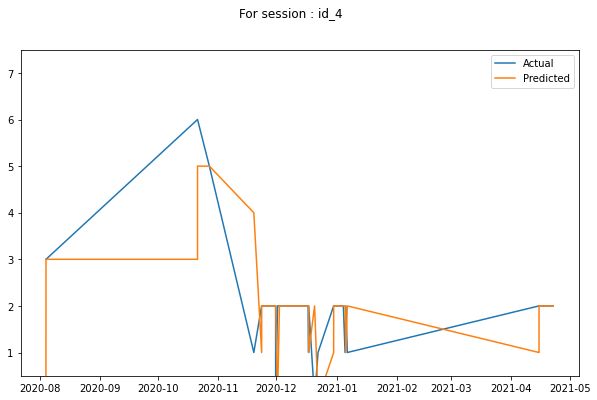

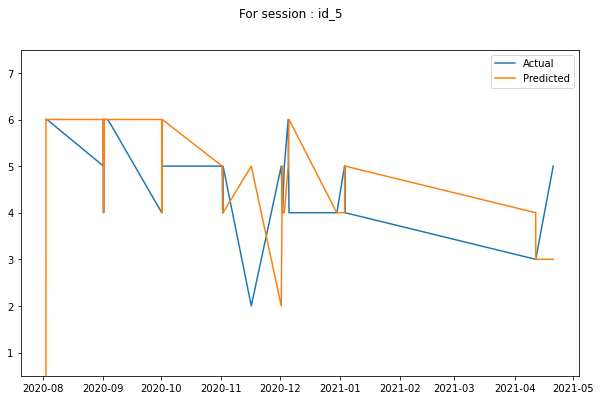

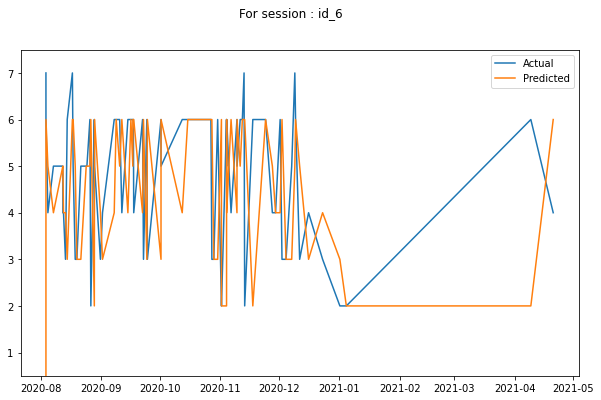

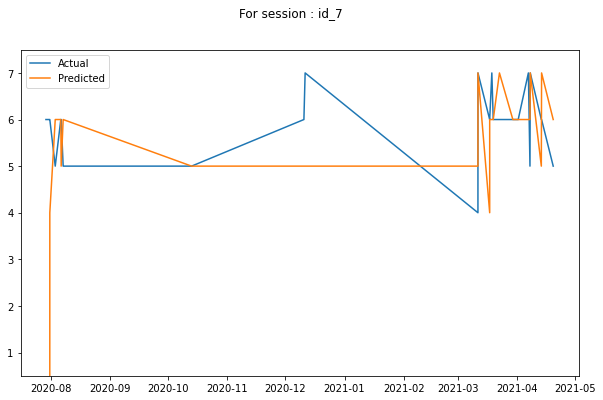

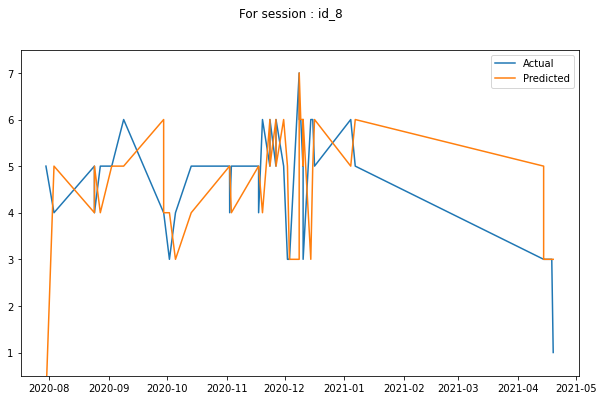

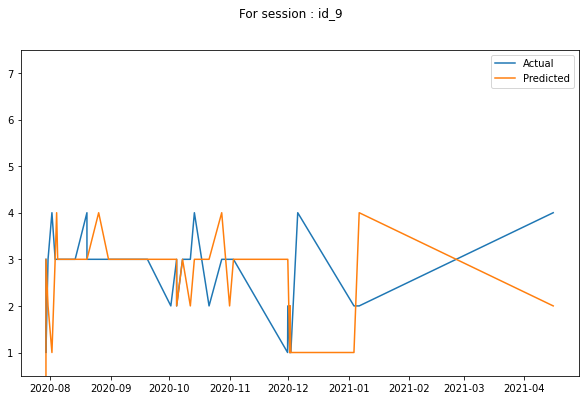

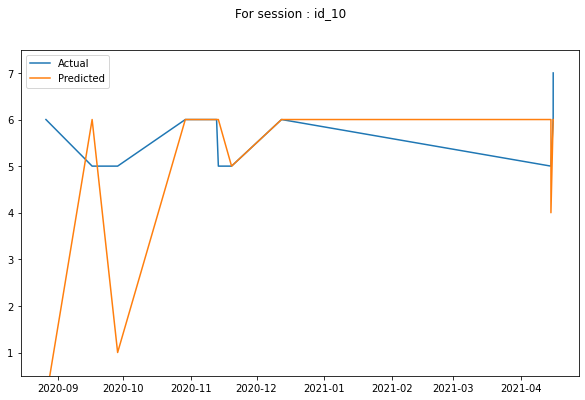

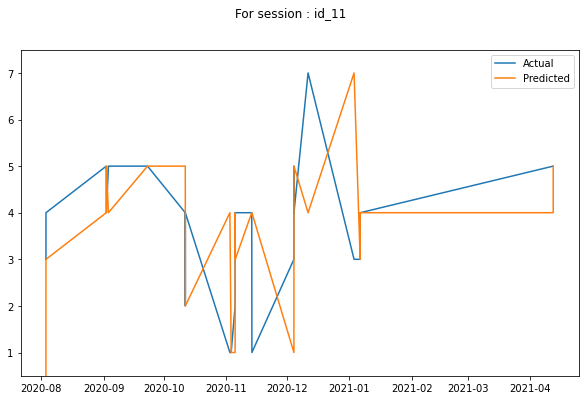

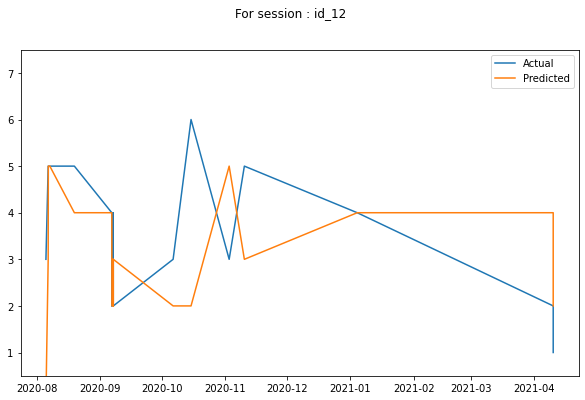

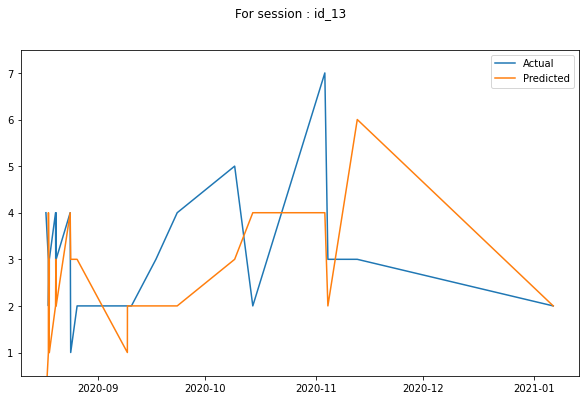

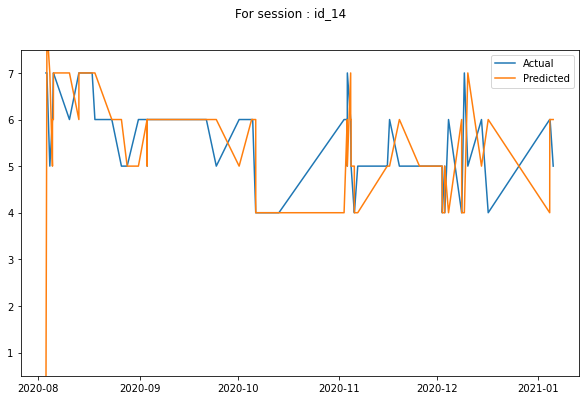

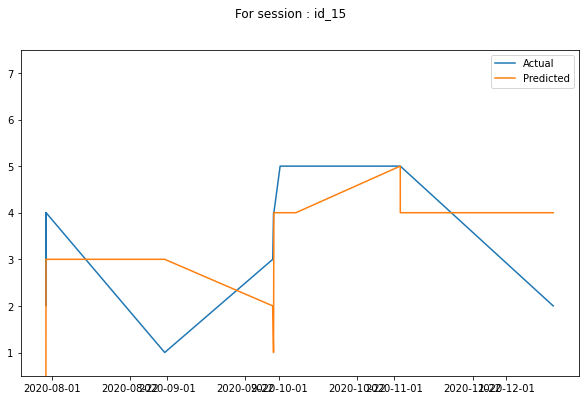

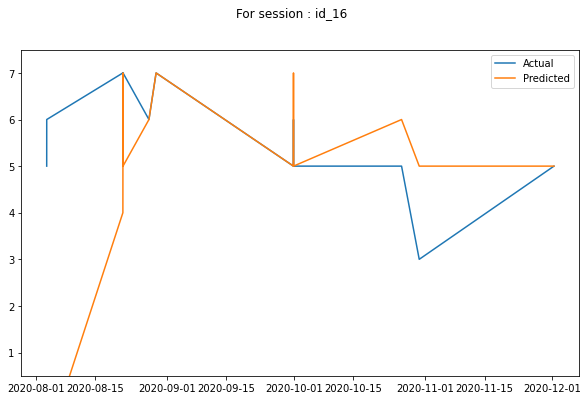

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

## 6. Prophet

In [ ]:
def calculate_fbprophet():
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    fb_rmse, fb_mae = [], []
    
    for session in final_data['scode'].unique():
        input_data = final_data[ final_data['scode'] == session ]

        input_data['ds'] = input_data.index
        #[ datetime.datetime(year=2020, month=1, day=1) + datetime.timedelta(days=index) 
        # for index in input_data.index ]
        input_data['y'] = list( input_data['level'].astype(int) )
        prophet = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(input_data)
        
        forecast = [ np.round(x)[0] for x in prophet.predict(prophet.make_future_dataframe(periods=len(input_data)))[['yhat']].values ]
        predicted_series = [ int(np.around(x)) for x in forecast[0:len(input_data)] ]
        actual_series = list(input_data['y'].values)
        
        testScore = accuracy_score(actual_series, predicted_series)
        print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data.index)
        RMSE = mean_squared_error(actual_series, predicted_series)
        print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
        fb_rmse.append(RMSE)
        MAE = mean_absolute_error(actual_series, predicted_series)
        print('MAE for '+ str(scode) + ' is: ' + str(MAE))
        fb_mae.append(MAE)

    print('-----------------------------------------')
    mean_mse, mean_mae = calculate_error(fb_rmse, fb_mae)
    print('Mean RMSE is:'+ str(mean_mse))
    print('Mean MAE is: '+ str(mean_mae))
      
    return accuracies, timestamps, actual_values, predicted_values

Mean RMSE is:1.2309138129340373 <br>
Mean MAE is: 0.7819354135847487

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_fbprophet()

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 20.


For id:  id_1  accuracy is :  0.3333333333333333
RMSE for id_16 is: 1.3333333333333333
MAE for id_16 is: 0.8571428571428571


INFO:prophet:n_changepoints greater than number of observations. Using 18.


For id:  id_2  accuracy is :  0.2962962962962963
RMSE for id_16 is: 0.9259259259259259
MAE for id_16 is: 0.7777777777777778
For id:  id_3  accuracy is :  0.375
RMSE for id_16 is: 1.75
MAE for id_16 is: 0.9166666666666666
For id:  id_4  accuracy is :  0.7450980392156863
RMSE for id_16 is: 1.1176470588235294
MAE for id_16 is: 0.45098039215686275
For id:  id_5  accuracy is :  0.45
RMSE for id_16 is: 0.825
MAE for id_16 is: 0.625


INFO:prophet:n_changepoints greater than number of observations. Using 19.


For id:  id_6  accuracy is :  0.15789473684210525
RMSE for id_16 is: 2.1447368421052633
MAE for id_16 is: 1.2236842105263157
For id:  id_7  accuracy is :  0.5384615384615384
RMSE for id_16 is: 0.5769230769230769
MAE for id_16 is: 0.5
For id:  id_8  accuracy is :  0.2391304347826087
RMSE for id_16 is: 1.565217391304348
MAE for id_16 is: 1.0


INFO:prophet:n_changepoints greater than number of observations. Using 10.


For id:  id_9  accuracy is :  0.6153846153846154
RMSE for id_16 is: 0.6153846153846154
MAE for id_16 is: 0.46153846153846156
For id:  id_10  accuracy is :  0.5714285714285714
RMSE for id_16 is: 0.42857142857142855
MAE for id_16 is: 0.42857142857142855


INFO:prophet:n_changepoints greater than number of observations. Using 17.


For id:  id_11  accuracy is :  0.3333333333333333
RMSE for id_16 is: 1.8181818181818181
MAE for id_16 is: 0.9696969696969697


INFO:prophet:n_changepoints greater than number of observations. Using 20.


For id:  id_12  accuracy is :  0.2608695652173913
RMSE for id_16 is: 1.608695652173913
MAE for id_16 is: 1.0
For id:  id_13  accuracy is :  0.2962962962962963
RMSE for id_16 is: 1.7037037037037037
MAE for id_16 is: 0.9629629629629629


INFO:prophet:n_changepoints greater than number of observations. Using 8.


For id:  id_14  accuracy is :  0.5280898876404494
RMSE for id_16 is: 0.6741573033707865
MAE for id_16 is: 0.5393258426966292


INFO:prophet:n_changepoints greater than number of observations. Using 10.


For id:  id_15  accuracy is :  0.16666666666666666
RMSE for id_16 is: 1.75
MAE for id_16 is: 1.0833333333333333
For id:  id_16  accuracy is :  0.35714285714285715
RMSE for id_16 is: 0.8571428571428571
MAE for id_16 is: 0.7142857142857143
-----------------------------------------
Mean RMSE is:1.2309138129340373
Mean MAE is: 0.7819354135847487


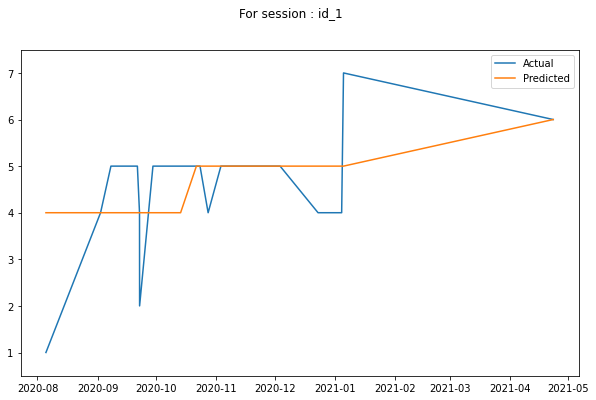

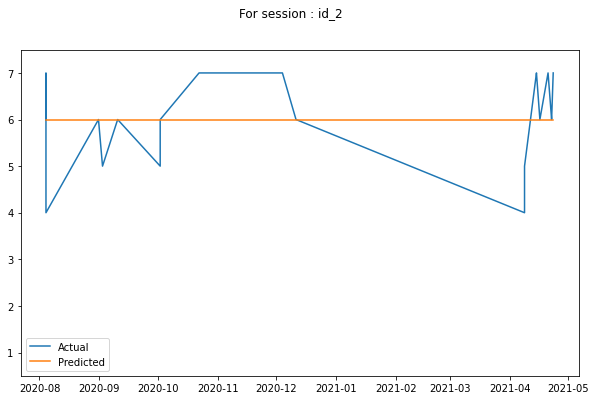

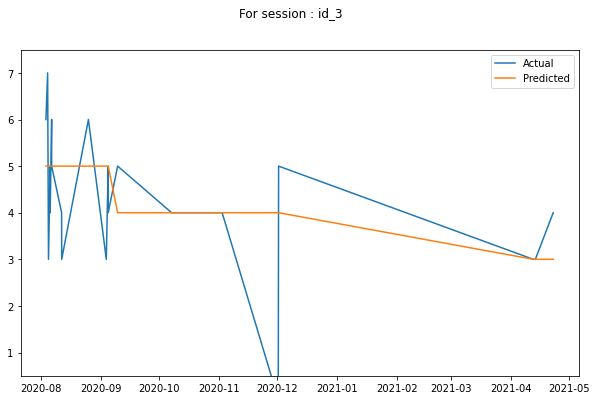

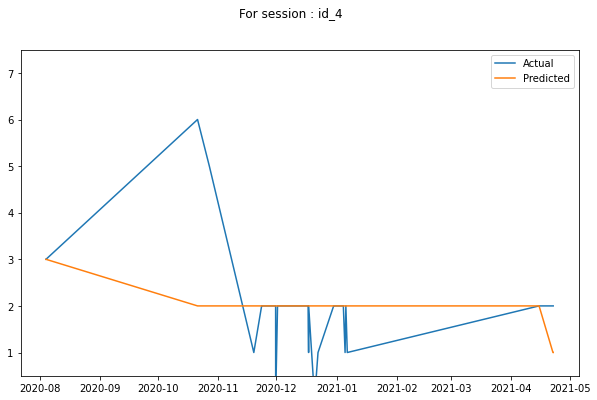

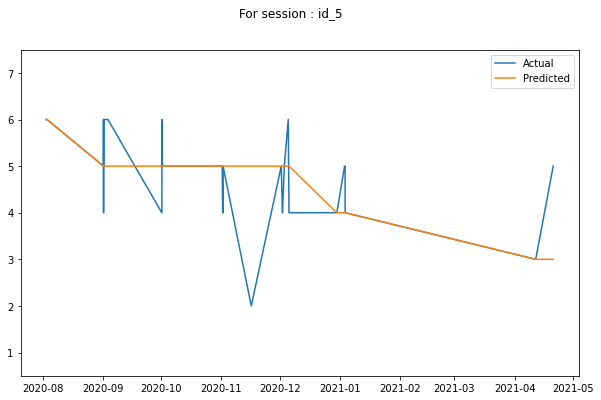

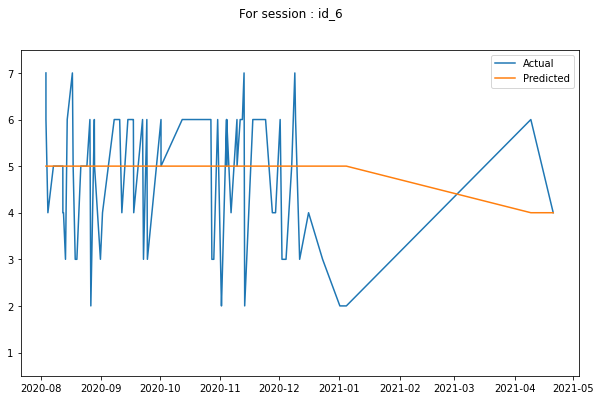

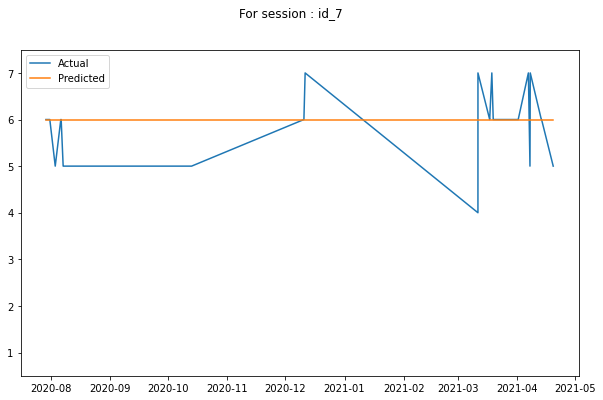

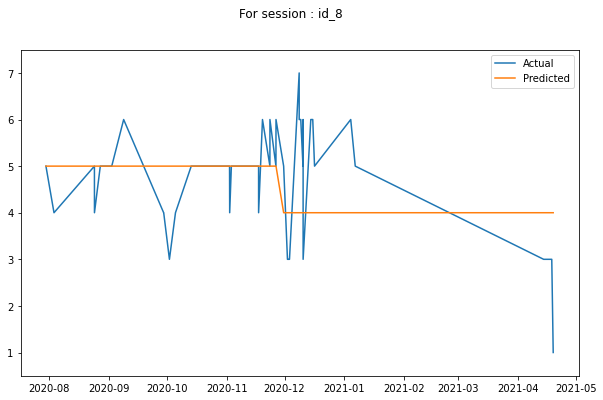

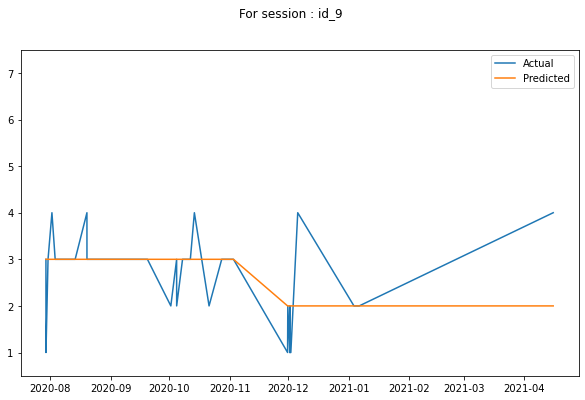

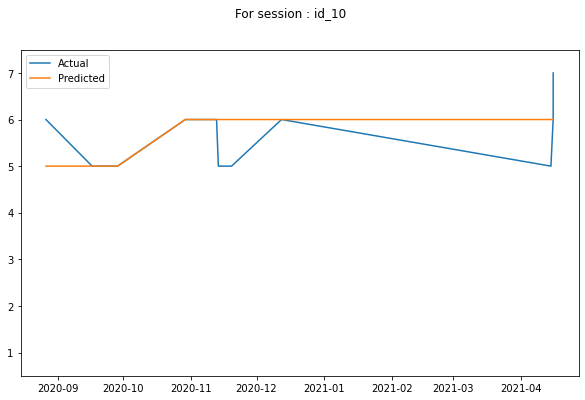

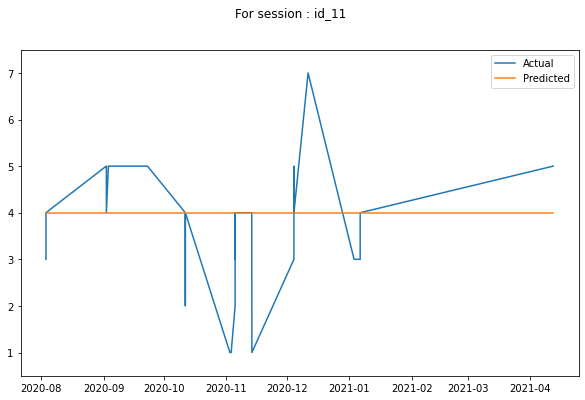

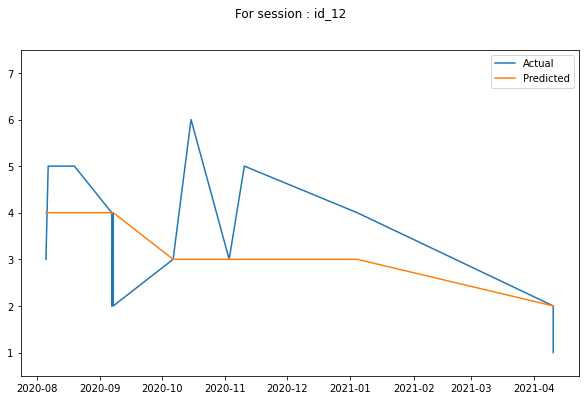

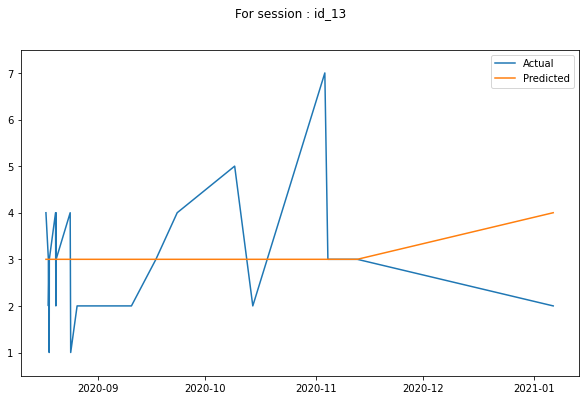

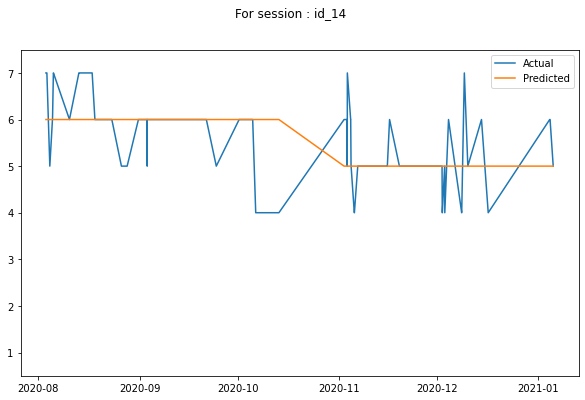

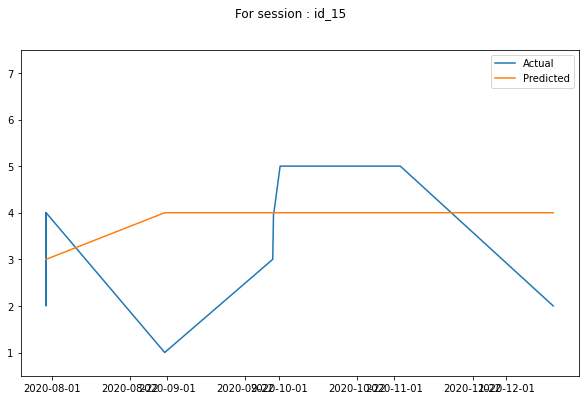

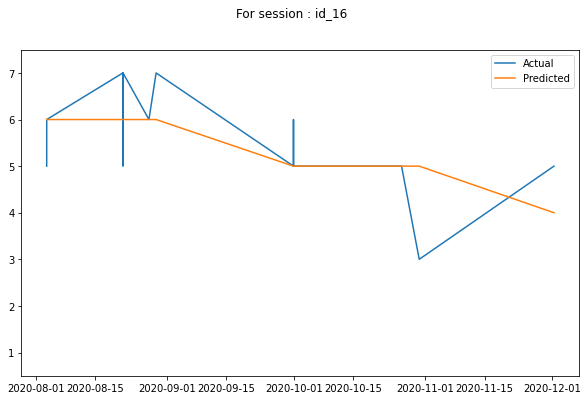

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

## 7. Winter Holtz method

In [ ]:
def calculate_winter_holtz(sp=2, seasonal='add', trend='add', log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    wh_rmse, wh_mae = [], []
    
    for session in final_data['scode'].unique():
        input_data = final_data[ final_data['scode'] == session ]
        actual_series = list( input_data['level'].astype(int) )
        if len(actual_series) <= sp:
            continue
        try:
          predicted_series = ExponentialSmoothing(actual_series, seasonal_periods=sp, seasonal=seasonal, trend=trend).fit().fittedvalues
        except:
            continue

        predicted_series = [ int(np.round(x)) for x in predicted_series ]
        # print(predicted_values)
        testScore = accuracy_score(actual_series, predicted_series)
        # print(testScore)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data.index)
        # print(accuracies)
        RMSE = mean_squared_error(actual_series, predicted_series)
        print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
        wh_rmse.append(RMSE)
        MAE = mean_absolute_error(actual_series, predicted_series)
        print('MAE for '+ str(scode) + ' is: ' + str(MAE))
        wh_mae.append(MAE)

    print('-----------------------------------------')
    mean_mse, mean_mae = calculate_error(wh_rmse, wh_mae)
    print('Mean RMSE is:'+ str(mean_mse))
    print('Mean MAE is: '+ str(mean_mae))
        
    return accuracies, timestamps, actual_values, predicted_values

Mean RMSE is:1.1465662132407604 <br>
Mean MAE is: 0.7855744722833831

In [ ]:
for seasonal in ['add', 'mult']:
    for trend in ['add', 'mult']:
        for sp in [2,3]:
            accuracies, timestamps, actual_values, predicted_values = calculate_winter_holtz(sp, 'add', 'add', log=False)
            print('Average accuracy for Expontential Winter Holtz method for period : {}, seasonal : {} and trend : {} is : {}'.format(
                sp, seasonal, trend, sum(accuracies)/len(accuracies)))

RMSE for id_16 is: 1.1428571428571428
MAE for id_16 is: 0.8571428571428571
RMSE for id_16 is: 1.0
MAE for id_16 is: 0.7777777777777778
RMSE for id_16 is: 1.5
MAE for id_16 is: 0.9166666666666666
RMSE for id_16 is: 0.9607843137254902
MAE for id_16 is: 0.49019607843137253
RMSE for id_16 is: 0.65
MAE for id_16 is: 0.6
RMSE for id_16 is: 2.013157894736842
MAE for id_16 is: 1.1710526315789473
RMSE for id_16 is: 0.6153846153846154
MAE for id_16 is: 0.5384615384615384
RMSE for id_16 is: 1.2826086956521738
MAE for id_16 is: 0.7608695652173914
RMSE for id_16 is: 0.717948717948718
MAE for id_16 is: 0.5128205128205128
RMSE for id_16 is: 0.5714285714285714
MAE for id_16 is: 0.5714285714285714
RMSE for id_16 is: 2.0303030303030303
MAE for id_16 is: 1.0606060606060606
RMSE for id_16 is: 1.3043478260869565
MAE for id_16 is: 0.8695652173913043
RMSE for id_16 is: 1.3333333333333333
MAE for id_16 is: 0.9629629629629629
RMSE for id_16 is: 0.7303370786516854
MAE for id_16 is: 0.5280898876404494
RMSE for i

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_winter_holtz(sp=3)

For id:  id_1  accuracy is :  0.23809523809523808
RMSE for id_16 is: 1.2857142857142858
MAE for id_16 is: 0.9047619047619048
For id:  id_2  accuracy is :  0.37037037037037035
RMSE for id_16 is: 0.8518518518518519
MAE for id_16 is: 0.7037037037037037
For id:  id_3  accuracy is :  0.3333333333333333
RMSE for id_16 is: 1.25
MAE for id_16 is: 0.8333333333333334
For id:  id_4  accuracy is :  0.6470588235294118
RMSE for id_16 is: 0.9803921568627451
MAE for id_16 is: 0.5098039215686274
For id:  id_5  accuracy is :  0.5
RMSE for id_16 is: 0.65
MAE for id_16 is: 0.55
For id:  id_6  accuracy is :  0.15789473684210525
RMSE for id_16 is: 2.1842105263157894
MAE for id_16 is: 1.236842105263158
For id:  id_7  accuracy is :  0.5384615384615384
RMSE for id_16 is: 0.5769230769230769
MAE for id_16 is: 0.5
For id:  id_8  accuracy is :  0.2391304347826087
RMSE for id_16 is: 1.5434782608695652
MAE for id_16 is: 0.9782608695652174
For id:  id_9  accuracy is :  0.48717948717948717
RMSE for id_16 is: 0.9487179

In [ ]:
print('Average accuracy via Winter Holtz method is : ', sum(accuracies)/len(accuracies))

Average accuracy via Winter Holtz method is :  0.43288556211707646


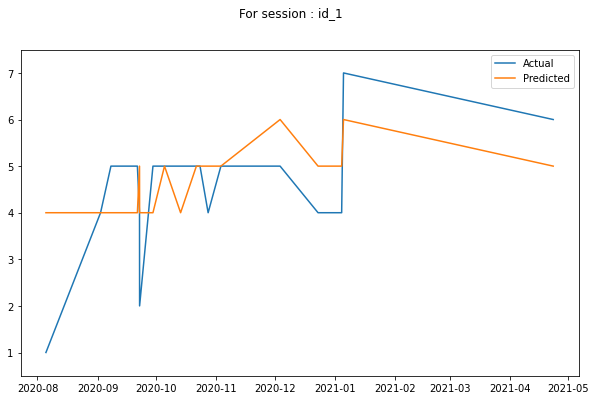

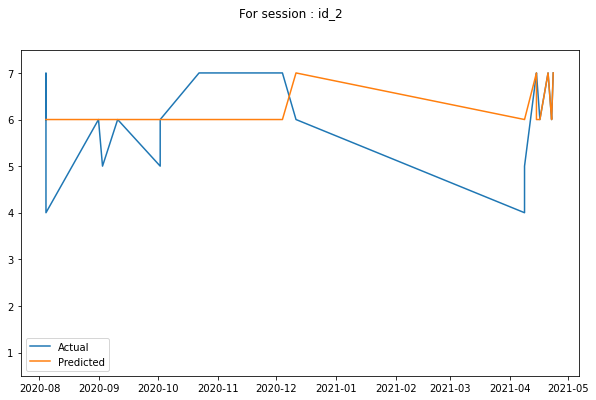

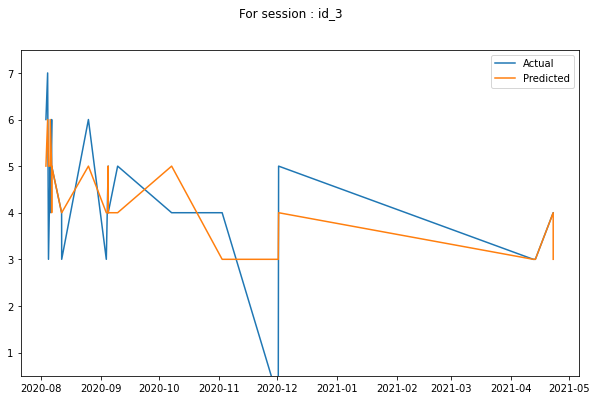

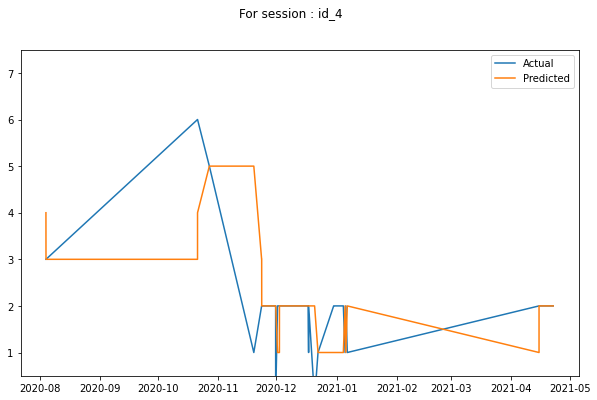

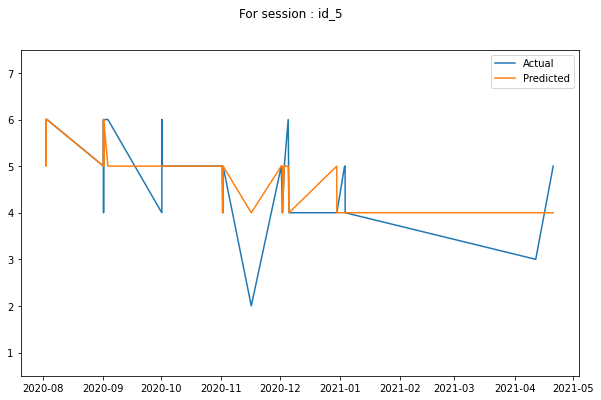

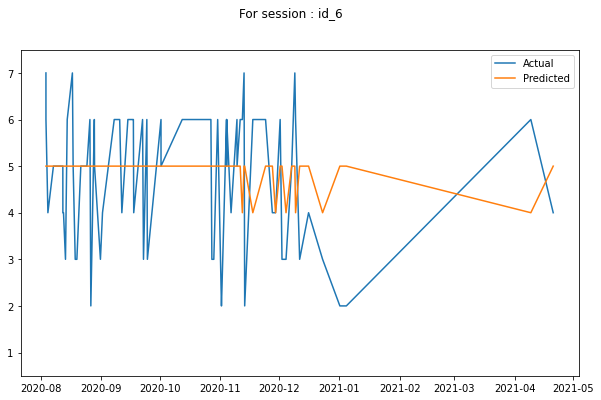

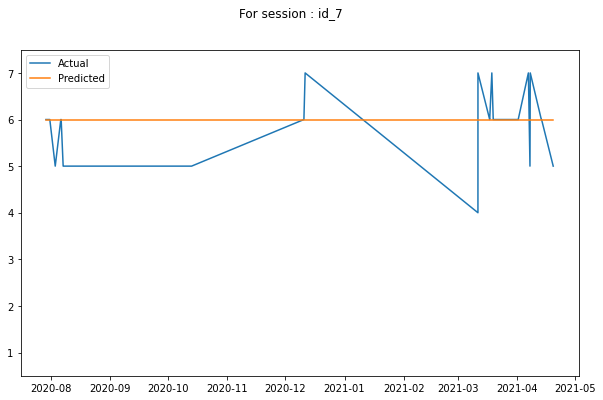

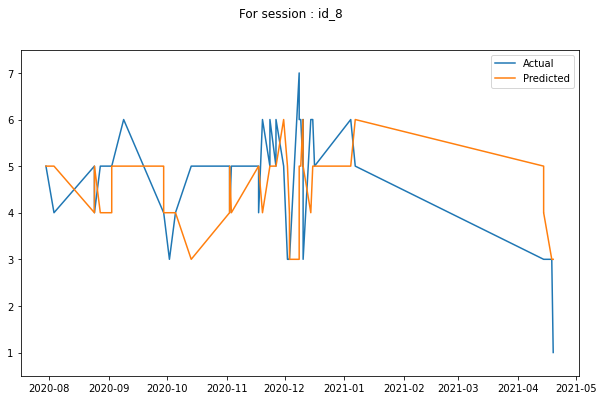

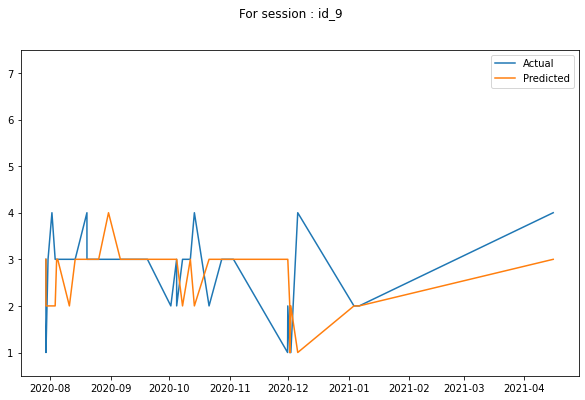

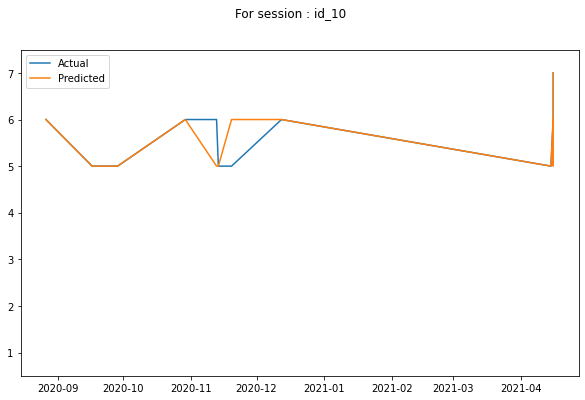

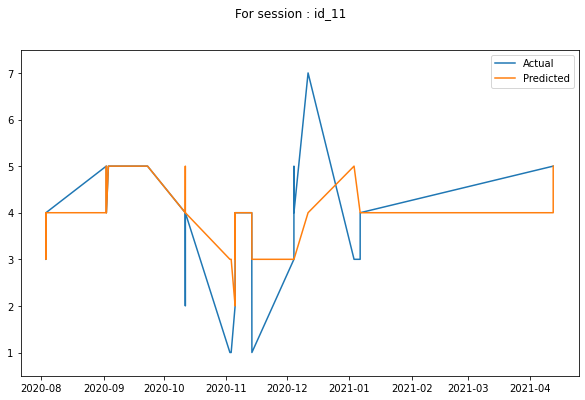

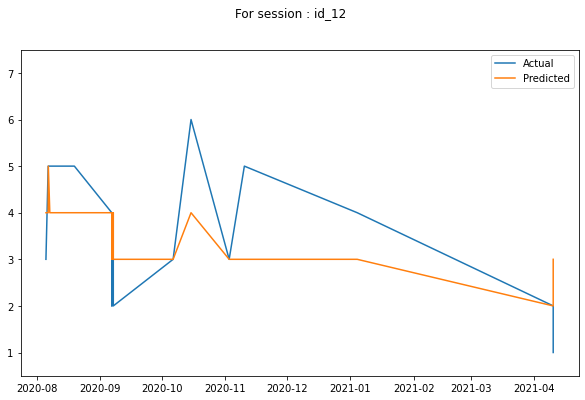

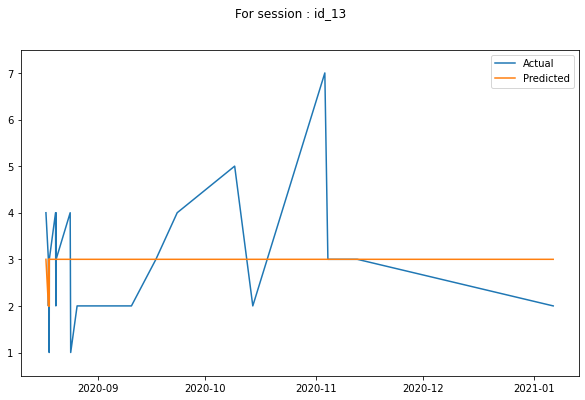

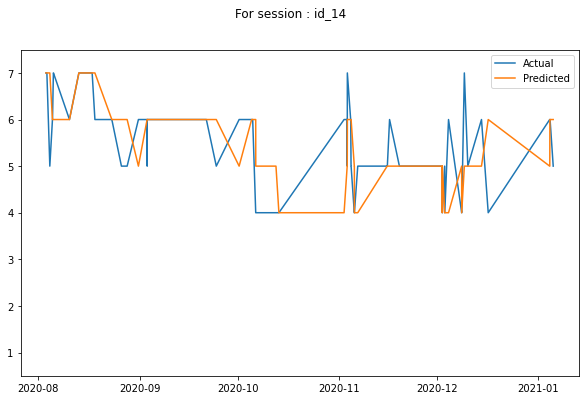

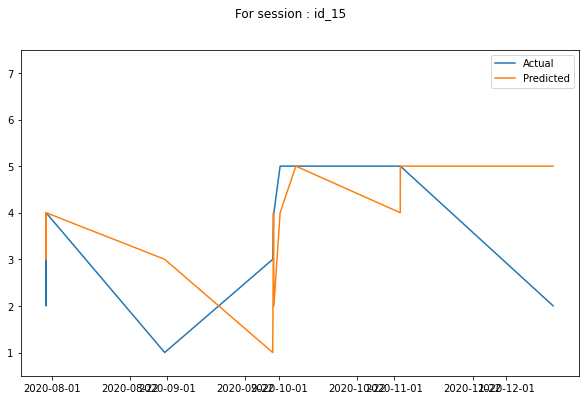

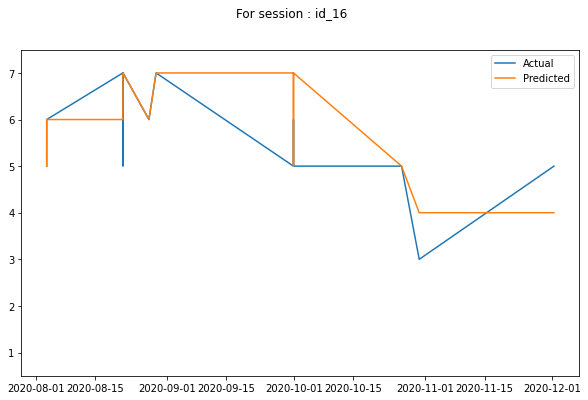

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

## FInal Verdict

FBProphet gives higher accuracy and lower RMSE and MAE. So, FBProphet  stands out in all the of the Time series algorithms comparison.

## Predictions from FBProphet are marked below:-

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 10.


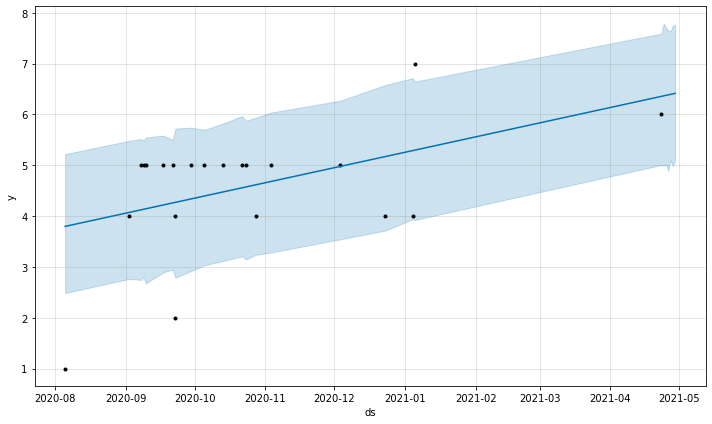

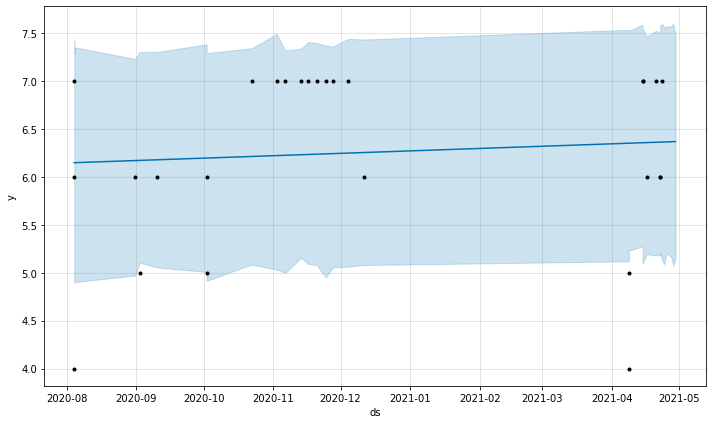

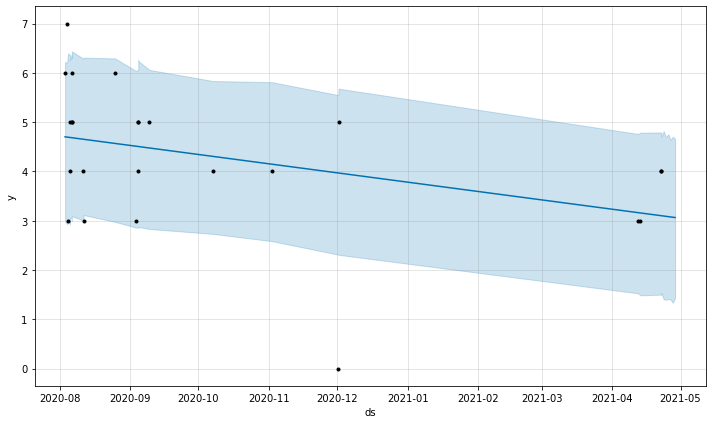

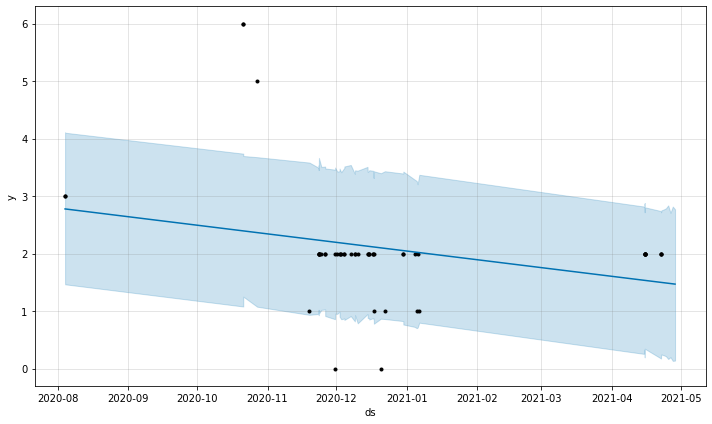

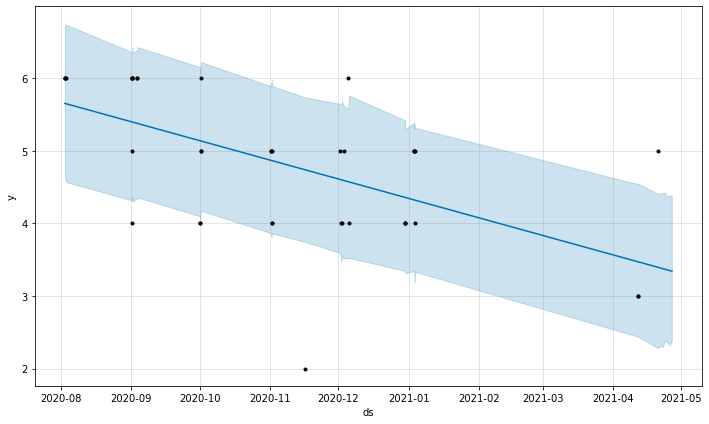

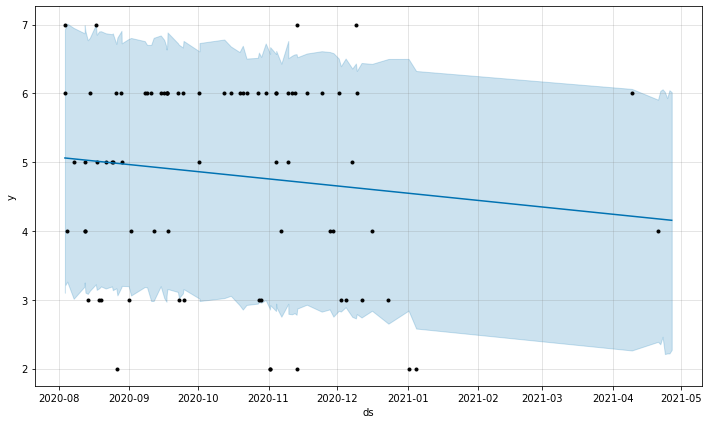

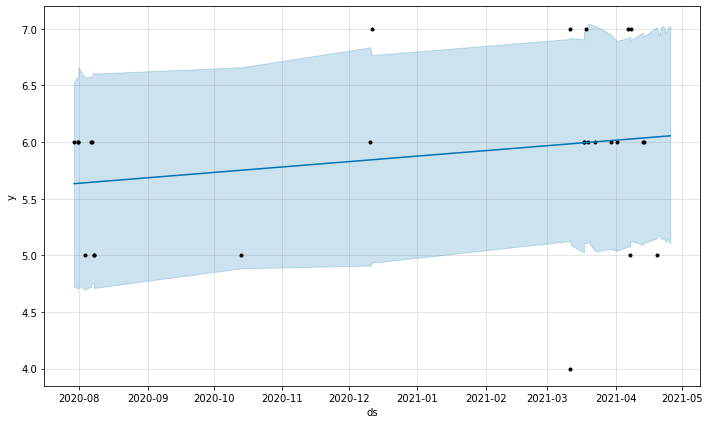

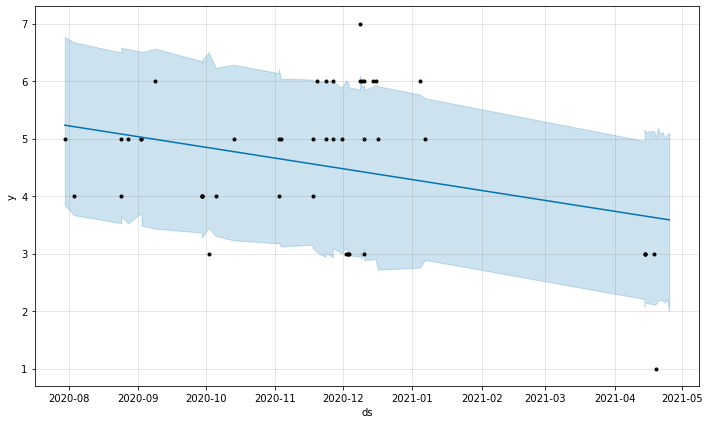

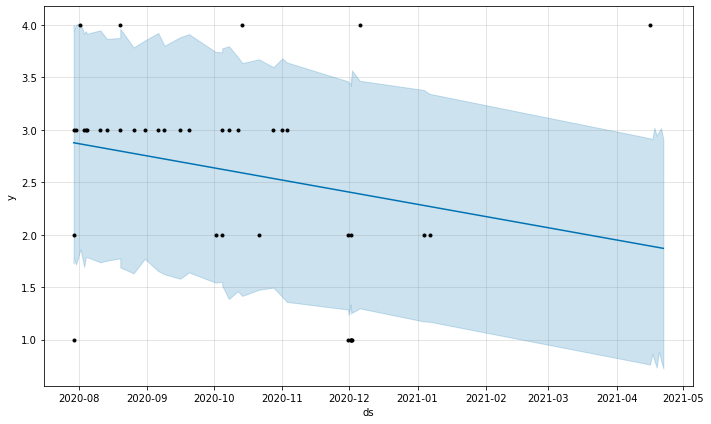

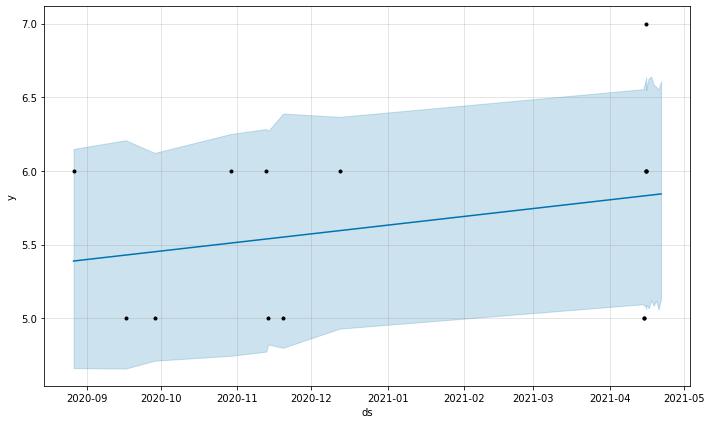

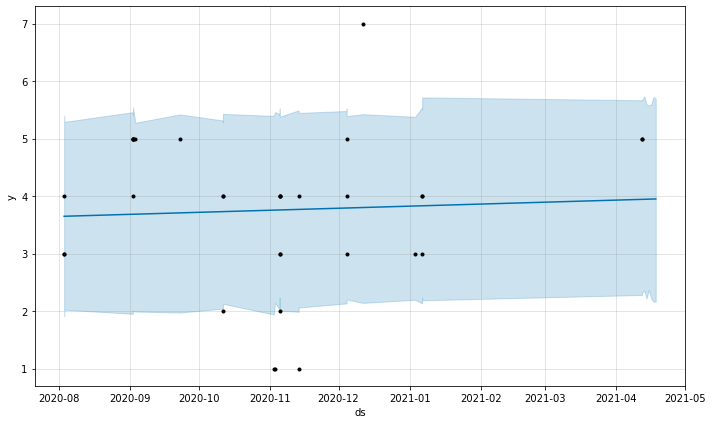

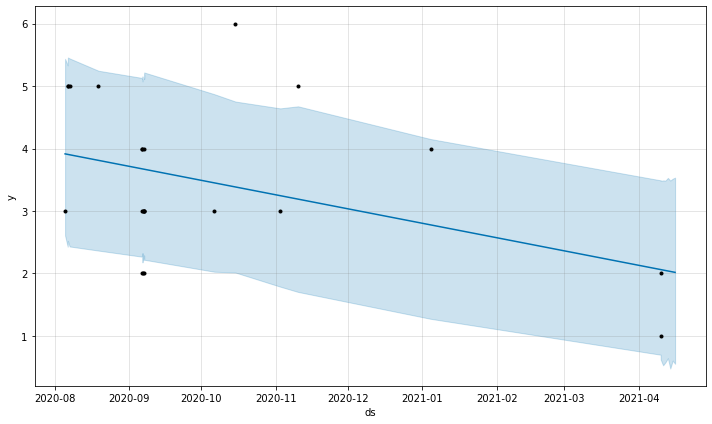

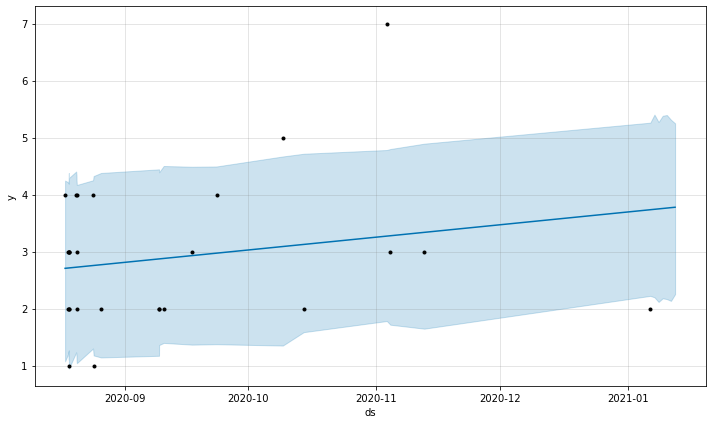

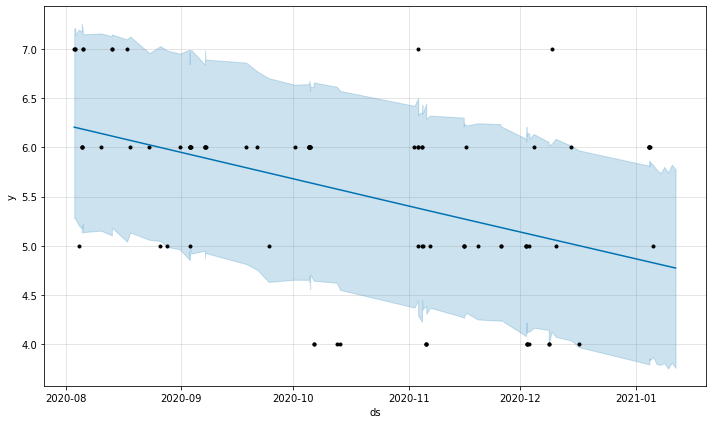

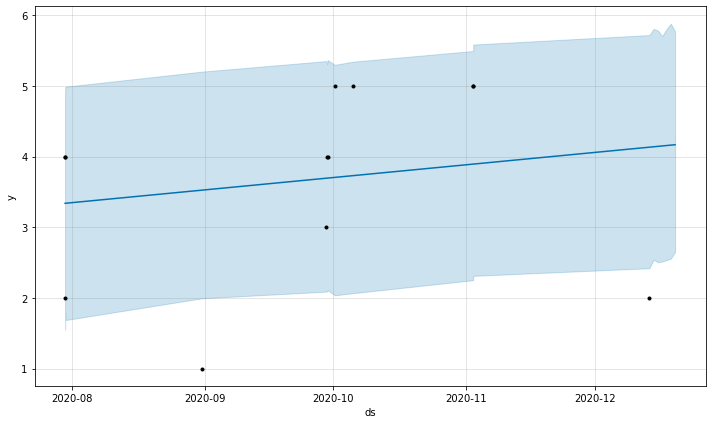

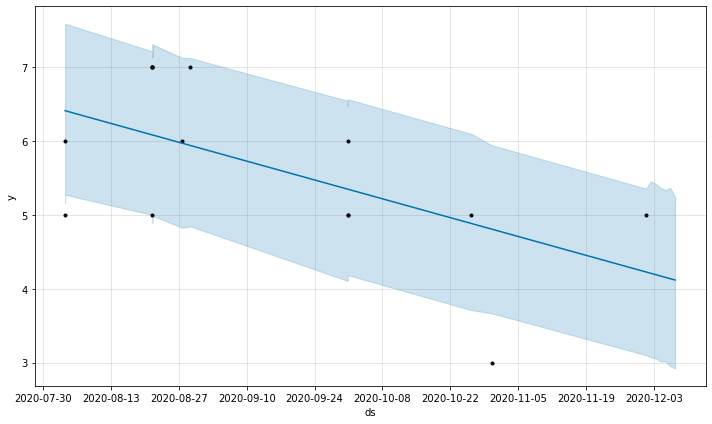

In [ ]:
for session in final_data['scode'].unique():
    input_data = final_data[ final_data['scode'] == session ]

    input_data['ds'] = input_data.index
    input_data['y'] = list( input_data['level'].astype(int) )
    prophet = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    prophet.fit(input_data)
     
    
    future_dates=prophet.make_future_dataframe(periods=6)
    prediction= prophet.predict(future_dates)
    prediction.head()
    # print(str(session))
    # plot_prediction(prophet, prediction, session)
    prophet.plot(prediction)

  ## Conclusion:-

1. Data points for each ID were very less. Due to which, the models are mostly underfitting (are not able to learn properly).
2. Time series frequency is very irregular (data is collected at irregular intervals).
3. Train-Test split could not be done on very less data. So, we used Backtesting to test  how the model is performing on the actual dataset.
4. FBProphet stands out in the compared machine learning model.
5. Data should contain atleast 250 observations for Time series model to learn properly. 
6. Acuracy, RMSE, MAE was used to compare the performance of the models.
7. MAPE( Mean Absolute Percentage) was not used as it gives import errors, because it is in sklearn's new version(0.14). However, Anaconda still offers skleanr 0.12.